<a href="https://colab.research.google.com/github/jtw0812/My_project/blob/main/AIM_nh%ED%88%AC%EC%9E%90%EC%A6%9D%EA%B6%8C_%EA%B3%A0%EA%B0%9D%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NH투자증권 고객분석

- 팀명: AIM
- 주제명: 다이렉트 인덱싱 제안을 위한 증권사 고객정보 및 거래양상에 따른 고객세분화
------------
- 개발환경
> 1. Google Colab 환경
> 2. Python --version: 3.7.14
> 3. 라이브러리 버전

| libraries  | version |
|------------|---------|
| matplotlib | 3.2.2   |
| numpy      | 1.21.6  |
| pandas     | 1.3.5   |
| seaborn    | 0.11.2  |
| requests   | 2.23.0  |
| kmodes     | 0.12.2  |
| plotnine   | 0.8.0   |
| scipy      | 1.7.3   |

## 사용할 패키지 불러오기

In [ ]:
def fix_font():
    import os
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    os.system("apt-get install -y fonts-nanum")
    os.system("fc-cache -fv")
    mpl.font_manager._rebuild()
    findfont = mpl.font_manager.fontManager.findfont
    mpl.font_manager.findfont = findfont
    mpl.backends.backend_agg.findfont = findfont
    plt.rcParams['font.family'] = "NanumBarunGothic"
    plt.rcParams['axes.unicode_minus'] = False

fix_font()

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

import zipfile
import warnings

import requests
import json
from pandas.io.json import json_normalize
warnings.filterwarnings('ignore')

## 데이터 다운로드 & 불러오기

In [ ]:
!gdown --id 1Qwz-dFgLNcC9zEXY3mqHoLVr73qOgTTv
zf = zipfile.ZipFile("경진대회 예선 데이터.zip")
zf.setpassword(b"nh1212!")
zf.extractall()

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Qwz-dFgLNcC9zEXY3mqHoLVr73qOgTTv
To: /content/경진대회 예선 데이터.zip
100% 12.5M/12.5M [00:00<00:00, 37.5MB/s]


In [ ]:
!gdown https://drive.google.com/uc?id=1_iiQX-OuwVgm5uftMazZOG7FjI4r-aeG
zf = zipfile.ZipFile("data.zip")
zf.extractall()
#  https://drive.google.com/file/d/1_iiQX-OuwVgm5uftMazZOG7FjI4r-aeG/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1_iiQX-OuwVgm5uftMazZOG7FjI4r-aeG
To: /content/data.zip
100% 2.07M/2.07M [00:00<00:00, 175MB/s]


In [ ]:
고객정보 = pd.read_csv('./cus_ifo.csv')
국내주식 = pd.read_csv('./kr_stk_orr.csv')
해외주식 = pd.read_csv('./oss_stk_orr.csv')
자산정보 = pd.read_csv('./cus_tot_aet_ifo.csv')
잔고정보 = pd.read_csv('./cus_itg_sct_bnc.csv')
종목데이터 = pd.read_excel('./data_1006_20221007.xlsx') ##외부데이터.. 종목코드를 종목명으로 보기 위함
코스피종목월봉 = pd.read_excel('./data_5400_20221009.xlsx') ##외부데이터.. 월별 코스피 종목가격 데이터
코스닥종목월봉 = pd.read_excel('./data_5531_20221009.xlsx') ##외부데이터.. 월별 코스닥 종목가격 데이터
신규상장종목 = pd.read_excel('./신규상장기업현황.xlsx') ##외부데이터.. 신규상장종목을 종목명으로 구분하기 위함.
url = 'https://finance.naver.com/api/sise/etfItemList.nhn'          ##외부데이터.. etf종목코드를 etf명으로 보기 위함
json_data = json.loads(requests.get(url).text)
etf데이터 = json_normalize(json_data['result']['etfItemList'])

나중에 데이터 전처리과정 마지막에 데이터프레임에 붙여줄 종목명을 미리 만들어둡니다.

In [ ]:
종목 = 종목데이터[['단축코드','한글 종목약명']]
종목['단축코드'] = 'A' + 종목['단축코드']
종목.rename(columns= {'단축코드':'종목명', '한글 종목약명':'종목'}, inplace= True)

etf = etf데이터[['itemcode','itemname']]
etf['itemcode'] = 'A' + etf['itemcode']
etf.rename(columns= {'itemcode':'종목명', 'itemname':'종목'}, inplace= True)

종목 = pd.concat([종목, etf], axis=0)

## 데이터 전처리1

고객거래데이터를 분석하기 위해서 거래정보, 고객정보, 자산정보, 잔고정보를 연결하는 데이터 전처리과정을 진행하였습니다.

In [ ]:
고객정보

,cus_no,act_no,bse_ym,mts_mm_access_type,sex_dit_cd,cus_age_stn_cd,cus_aet_stn_cd,pft_amt_stn_cd,fst_act_opn_dt,stk_pdt_hld_yn,...,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,hld_pdt_tp_sgm_cd,loy_sgm_cd,mrz_mkt_dit_cd,mrz_btp_dit_cd,aet_bse_stk_trd_tp_cd,bas_stk_trd_tp_cd
0,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202203,111111,1,4,1,1,20050309,Y,...,2,3,9,3,1.0,5.0,1.0,6.0,5.0,006
1,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202202,111111,1,4,1,1,20050309,Y,...,2,3,9,3,1.0,5.0,6.0,16.0,5.0,010
2,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202206,111111,1,4,1,1,20050309,Y,...,2,3,9,3,1.0,4.0,6.0,16.0,5.0,009
3,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202205,111111,1,4,1,1,20050309,Y,...,2,3,9,3,1.0,4.0,6.0,16.0,5.0,008
4,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202201,111111,1,4,1,1,20050309,Y,...,2,3,9,3,1.0,5.0,6.0,16.0,5.0,010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59076,1b3dc5053fa9c52990872c97f85d54f3e8749eabf64b5d...,b41f38d7eedb84857fcc8fe2f58ded96aa3bbd85614d18...,202204,110100,2,3,1,1,20210802,N,...,3,4,9,1,1.0,5.0,6.0,16.0,5.0,010
59077,1b3dc5053fa9c52990872c97f85d54f3e8749eabf64b5d...,b41f38d7eedb84857fcc8fe2f58ded96aa3bbd85614d18...,202202,110100,2,3,1,1,20210802,N,...,3,4,9,1,1.0,5.0,6.0,16.0,5.0,010
59078,1b3dc5053fa9c52990872c97f85d54f3e8749eabf64b5d...,b41f38d7eedb84857fcc8fe2f58ded96aa3bbd85614d18...,202206,110100,2,3,1,1,20210802,N,...,3,4,9,1,1.0,5.0,6.0,16.0,5.0,010
59079,1b3dc5053fa9c52990872c97f85d54f3e8749eabf64b5d...,b41f38d7eedb84857fcc8fe2f58ded96aa3bbd85614d18...,202201,110100,2,3,1,1,20210802,N,...,3,4,9,1,1.0,5.0,6.0,16.0,5.0,010


1.월별로 고객데이터가 정리되어있기 때문에 월별로 데이터 전처리


In [ ]:
국내주식['orr_dt'] = 국내주식['orr_dt'].astype('str')
국내주식["orr_dt1"] = 국내주식['orr_dt'].str.slice(start=0, stop = 6) ##연도월로 자르기.. 월별로 거래종목 파악하기 위함
국내주식['월계좌'] = 국내주식['act_no'] + '' + 국내주식['orr_dt1']
국내주식['iem_cd'] = 국내주식['iem_cd'].str.strip() ##종목코드 뒷 공백 제거

해외주식['orr_dt'] = 해외주식['orr_dt'].astype('str')
해외주식["orr_dt1"] = 해외주식['orr_dt'].str.slice(start=0, stop = 6) ##연도월로 자르기.. 월별로 거래종목 파악하기 위함
해외주식['월계좌'] = 해외주식['act_no'] + '' + 해외주식['orr_dt1']


고객정보['bse_ym'] = 고객정보['bse_ym'].astype('str')
고객정보['월계좌']= 고객정보['act_no'] + "" + 고객정보["bse_ym"]

잔고정보['bse_ym'] = 잔고정보['bse_ym'].astype('str')
잔고정보['월계좌']= 잔고정보['act_no'] + "" + 잔고정보["bse_ym"]

2.고객거래데이터에서 의미있는 내용을 찾기 위해 자산정보 데이터와 고객정보 중 중요하다고 판단되는 칼럼을 거래정보와 합치기

1) 월별 자산정보 데이터를 고객정보, 국내주식거래내역, 해외주식거래내역, 잔고정보 데이터와  합치기

In [ ]:
일월자산 = pd.concat([자산정보['act_no'] , 자산정보['tot_aet_tld_rnd_202201']], axis = 1)
일월자산['act_no'] =일월자산['act_no'] + '202201'
일월자산.rename(columns={'act_no':'월계좌','tot_aet_tld_rnd_202201':'월말자산'}, inplace=True)

이월자산 = pd.concat([자산정보['act_no'] , 자산정보['tot_aet_tld_rnd_202202']], axis = 1)
이월자산['act_no'] =이월자산['act_no'] + '202202'
이월자산.rename(columns={'act_no':'월계좌','tot_aet_tld_rnd_202202':'월말자산'}, inplace=True)

삼월자산 = pd.concat([자산정보['act_no'] , 자산정보['tot_aet_tld_rnd_202203']], axis = 1)
삼월자산['act_no'] =삼월자산['act_no'] + '202203'
삼월자산.rename(columns={'act_no':'월계좌','tot_aet_tld_rnd_202203':'월말자산'}, inplace=True)

사월자산 = pd.concat([자산정보['act_no'] , 자산정보['tot_aet_tld_rnd_202204']], axis = 1)
사월자산['act_no'] =사월자산['act_no'] + '202204'
사월자산.rename(columns={'act_no':'월계좌','tot_aet_tld_rnd_202204':'월말자산'}, inplace=True)

오월자산 = pd.concat([자산정보['act_no'] , 자산정보['tot_aet_tld_rnd_202205']], axis = 1)
오월자산['act_no'] =오월자산['act_no'] + '202205'
오월자산.rename(columns={'act_no':'월계좌','tot_aet_tld_rnd_202205':'월말자산'}, inplace=True)

유월자산 = pd.concat([자산정보['act_no'] , 자산정보['tot_aet_tld_rnd_202206']], axis = 1)
유월자산['act_no'] =유월자산['act_no'] + '202206'
유월자산.rename(columns={'act_no':'월계좌','tot_aet_tld_rnd_202206':'월말자산'}, inplace=True)

In [ ]:
a = pd.merge(고객정보,일월자산)
b = pd.merge(고객정보,이월자산)
c = pd.merge(고객정보,삼월자산)
d = pd.merge(고객정보,사월자산)
e = pd.merge(고객정보,오월자산)
f = pd.merge(고객정보,유월자산)
고객정보 = pd.concat([a,b,c,d,e,f])

In [ ]:
a = pd.merge(잔고정보,일월자산)
b = pd.merge(잔고정보,이월자산)
c = pd.merge(잔고정보,삼월자산)
d = pd.merge(잔고정보,사월자산)
e = pd.merge(잔고정보,오월자산)
f = pd.merge(잔고정보,유월자산)
잔고정보 = pd.concat([a,b,c,d,e,f])

In [ ]:
a = pd.merge(국내주식,일월자산)
b = pd.merge(국내주식,이월자산)
c = pd.merge(국내주식,삼월자산)
d = pd.merge(국내주식,사월자산)
e = pd.merge(국내주식,오월자산)
f = pd.merge(국내주식,유월자산)
국내주식 = pd.concat([a,b,c,d,e,f])

In [ ]:
a = pd.merge(해외주식,일월자산)
b = pd.merge(해외주식,이월자산)
c = pd.merge(해외주식,삼월자산)
d = pd.merge(해외주식,사월자산)
e = pd.merge(해외주식,오월자산)
f = pd.merge(해외주식,유월자산)
해외주식 = pd.concat([a,b,c,d,e,f])

2) 잔고정보에서는 '자산 대비 종목 비중'을 파생변수로,
해외주식과 국내주식은 '거래금액'과 '자산 대비 거래금액'을 파생 변수로 만들기

-자산 대비 종목 비중을 알아야 해당 거래가 얼마나 의미 있는지 알 수 있기 때문에 파생변수로 만들었습니다

In [ ]:
잔고정보['종목비중'] = 잔고정보['cns_bse_now_eal_amt']/잔고정보['월말자산']*100

해외주식['거래금액'] = 해외주식['cns_qty']*해외주식['orr_pr']*해외주식['trd_cur_xcg_rt'] ##환율까지 곱해서 원화로
해외주식['비중'] = 해외주식['거래금액']/해외주식['월말자산']*100

국내주식['거래금액'] = 국내주식['cns_qty']*국내주식['orr_pr']
국내주식['비중'] = 국내주식['거래금액']/국내주식['월말자산']*100

3) 고객거래데이터에 동일날에 나눠서 매수하는 등의 거래 데이터 왜곡이 있어서, 월별로 종목별 매수금액, 매도금액, 순매수금액을 종합해 종합적인 종목에 대한 거래내역을 알 수 있도록 하였습니다.(스캘핑 같이 반복적인 매매를 많이 한 경우, 거래금액비중 파생변수로 분석이 가능)

In [ ]:
국내주식매수= 국내주식[국내주식['sby_dit_cd']==2]
국내주식매수그룹 = 국내주식매수.groupby(['월계좌','iem_cd']).sum()

국내주식매도= 국내주식[국내주식['sby_dit_cd']==1]
국내주식매도그룹 = 국내주식매도.groupby(['월계좌','iem_cd']).sum()

In [ ]:
국내주식.loc[국내주식['sby_dit_cd'] == 1, '거래금액'] = 국내주식[국내주식['sby_dit_cd'] == 1]['거래금액'] * -1

국내주식그룹= 국내주식.groupby(['월계좌','iem_cd'])
국내주식그룹 = 국내주식그룹.sum() ##이 총 거래금액 테이블에다 매수, 매도 테이블을 붙여줘야한다. 왜냐하면 매수만 한 달도 있고, 매도만 한 달이 있기 때문이다. 이러한 경우 해당행은 결측값이 될 것이다. 나중에 결측값은 0으로 채워넣어준다.

In [ ]:
국내월별주식거래매수 = pd.DataFrame(국내주식매수그룹['거래금액'])
국내월별주식거래매수.reset_index(level=['월계좌','iem_cd'], inplace = True)
국내월별주식거래매수.rename(columns={'거래금액':'매수금액'}, inplace=True)

국내월별주식거래매도 = pd.DataFrame(국내주식매도그룹['거래금액'])
국내월별주식거래매도.reset_index(level=['월계좌','iem_cd'], inplace = True)
국내월별주식거래매도.rename(columns={'거래금액':'매도금액'}, inplace=True)

국내월별주식거래총계 = pd.DataFrame(국내주식그룹['거래금액'])
국내월별주식거래총계.reset_index(level=['월계좌','iem_cd'], inplace = True)
국내월별주식거래총계.rename(columns={'거래금액':'순매수금액'}, inplace=True)

In [ ]:
국내월별주식거래내역 = pd.merge(국내월별주식거래총계,국내월별주식거래매수, how = 'left')
국내월별주식거래내역 = pd.merge(국내월별주식거래내역,국내월별주식거래매도, how = 'left')
국내월별주식거래내역 = 국내월별주식거래내역.fillna(0) ##결측값은 매수 또는 매도를 안한 것이므로 0으로 채워넣어준다.

In [ ]:
국내월별주식거래내역

,월계좌,iem_cd,순매수금액,매수금액,매도금액
0,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,A377330,-23000.0,0.0,23000.0
1,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,A382900,-51200.0,0.0,51200.0
2,00086aa946369d1c75182dffd43bd4a34f3abc1ddeba03...,A000440,46000.0,2484000.0,2438000.0
3,00086aa946369d1c75182dffd43bd4a34f3abc1ddeba03...,A002710,0.0,596250.0,596250.0
4,00086aa946369d1c75182dffd43bd4a34f3abc1ddeba03...,A004250,-3100.0,626200.0,629300.0
...,...,...,...,...,...
107587,ffc0e6b3eaf8b59f8c471e4d6d68063106dc5bd2414ca5...,A001570,-264000.0,0.0,264000.0
107588,ffd96d859770d62800f6f654fce913c50f9cbf809efcc8...,A146320,-25000.0,0.0,25000.0
107589,ffdb8a101b04d93c8b09ddce17a7be84d0179908f3f4cc...,A101730,3419400.0,3419400.0,0.0
107590,ffdb8a101b04d93c8b09ddce17a7be84d0179908f3f4cc...,A112040,-3387900.0,0.0,3387900.0


4) 월별주식거래내역 테이블에 자산정보와 고객정보 테이블을 붙이고 파생 변수를 만들어줍니다.(순매수금액 비중, 매수금액비중, 매도금액비중)

4-1)잔고정보 붙여주기 -> 통합적인 월잔고 주식을 알 수 있고, 6개월간 비매매한 사람들이 어떤 주식을 들고 있는지도 알 수 있습니다.

In [ ]:
국내월별주식거래내역['월계좌종목'] = 국내월별주식거래내역['월계좌'] + 국내월별주식거래내역['iem_cd']
잔고정보['iem_cd'] = 잔고정보['iem_cd'].str.strip() ## 공백이 있어서 공백제거
잔고정보['월계좌종목'] = 잔고정보['월계좌'] + 잔고정보['iem_cd']
국내월별주식거래내역 = 국내월별주식거래내역[['월계좌종목','순매수금액','매수금액','매도금액']]

In [ ]:
국내주식거래분석 = pd.merge(국내월별주식거래내역,잔고정보 ,how='right')

국내주식거래분석 = 국내주식거래분석.fillna(0)
국내주식거래분석['순매수금액비중'] = 국내주식거래분석['순매수금액']/국내주식거래분석['월말자산']*100
국내주식거래분석['매수금액비중'] = 국내주식거래분석['매수금액']/국내주식거래분석['월말자산']*100
국내주식거래분석['매도금액비중'] = 국내주식거래분석['매도금액']/국내주식거래분석['월말자산']*100

월별로 고객 거래데이터와 잔고정보를 합치면 월별로 사람들이 의미있게(ex) 총자산의 10%이상) 매매한 종목들, 월별로 잔고에 남아있는 종목의 액수 및 비중을 알 수 있습니다. 이런 식으로 데이터를 전처리한 이유는 몇 가지 있습니다.
1. 금융상품이라는 것은 특성상 어느 정도 기간이 있어야 하고, 단기 트레이더들이 추구하는 단기 고수익 상품을 만드는 것이 사실상 불가능합니다. 그러므로 하루하루 사고 파는 데이터를 분석하기보다는 월별로 데이터를 종합하는 것이 투자큐레이터를 위한 고객분석에는 더 적합하다고 생각했습니다.
2. 자산정보나 잔고정보의 데이터 형태를 보면  한달 단위로 종합해서 고객별로 정리를 해놨습니다. 데이터 형태상 월별로 데이터를 전처리하는 것이 더 유리하다고 생각을 하였습니다.
3. 단순히 한주씩 사고 판 거래데이터들이 갖고 오는 왜곡을 줄여 조금이라도 더 사실(고객들이 진심으로 투자한 거래데이터)과 가까운 분석을 할 수 있도록 하였습니다.

4-2) 고객정보 붙여주고 컬럼 정리 및 이름 바꿔주기

In [ ]:
국내주식거래분석 =pd.merge(국내주식거래분석, 고객정보, left_on = '월계좌', right_on='월계좌', how = 'left')

In [ ]:
국내주식거래분석 = 국내주식거래분석[국내주식거래분석['cur_cd'] == 'KRW'] ##국내주식만 추리기

In [ ]:
국내주식거래분석

,월계좌종목,순매수금액,매수금액,매도금액,act_no_x,bse_ym_x,iem_cd,fc_sec_trd_nat_cd,itg_pdt_tp_cd,stl_bse_itg_bnc_qty,...,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,hld_pdt_tp_sgm_cd,loy_sgm_cd,mrz_mkt_dit_cd,mrz_btp_dit_cd,aet_bse_stk_trd_tp_cd,bas_stk_trd_tp_cd,월말자산_y
0,e97920ce7d2205d876398178d56a854ebe6aa84f46a9ff...,1560.0,1560.0,0.0,e97920ce7d2205d876398178d56a854ebe6aa84f46a9ff...,202201,A080530,0,10,0.0,...,7,4,4,1.0,4.0,2.0,10.0,3.0,001,35510000.0
1,e97920ce7d2205d876398178d56a854ebe6aa84f46a9ff...,0.0,0.0,0.0,e97920ce7d2205d876398178d56a854ebe6aa84f46a9ff...,202201,A293580,0,10,1.0,...,7,4,4,1.0,4.0,2.0,10.0,3.0,001,35510000.0
2,e97920ce7d2205d876398178d56a854ebe6aa84f46a9ff...,92700.0,92700.0,0.0,e97920ce7d2205d876398178d56a854ebe6aa84f46a9ff...,202201,A009470,0,10,3.0,...,7,4,4,1.0,4.0,2.0,10.0,3.0,001,35510000.0
3,e97920ce7d2205d876398178d56a854ebe6aa84f46a9ff...,0.0,0.0,0.0,e97920ce7d2205d876398178d56a854ebe6aa84f46a9ff...,202201,A072130,0,10,100.0,...,7,4,4,1.0,4.0,2.0,10.0,3.0,001,35510000.0
4,e97920ce7d2205d876398178d56a854ebe6aa84f46a9ff...,45900.0,487900.0,442000.0,e97920ce7d2205d876398178d56a854ebe6aa84f46a9ff...,202201,A263050,0,10,17.0,...,7,4,4,1.0,4.0,2.0,10.0,3.0,001,35510000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366792,14b6c2ef1b9f411b39bb88cc58bc11519545a2843a2046...,0.0,0.0,0.0,14b6c2ef1b9f411b39bb88cc58bc11519545a2843a2046...,202206,A378160,0,10,195.0,...,6,5,3,1.0,5.0,1.0,9.0,4.0,004,10792644.0
366793,14b6c2ef1b9f411b39bb88cc58bc11519545a2843a2046...,116400.0,116400.0,0.0,14b6c2ef1b9f411b39bb88cc58bc11519545a2843a2046...,202206,A005930,0,10,82.0,...,6,5,3,1.0,5.0,1.0,9.0,4.0,004,10792644.0
366794,14b6c2ef1b9f411b39bb88cc58bc11519545a2843a2046...,0.0,0.0,0.0,14b6c2ef1b9f411b39bb88cc58bc11519545a2843a2046...,202206,A005380,0,10,29.0,...,6,5,3,1.0,5.0,1.0,9.0,4.0,004,10792644.0
366795,8a302c32df0a3110af9fea8285cb720cfba9cd57b87123...,0.0,0.0,0.0,8a302c32df0a3110af9fea8285cb720cfba9cd57b87123...,202206,A353590,0,10,2.0,...,2,9,1,1.0,5.0,6.0,16.0,5.0,010,199473.0


In [ ]:
국내주식거래분석.columns ##중복칼럼 및 쓸모없는 칼럼 제거
국내주식거래분석.drop(columns = ['월계좌종목','act_no_x','bse_ym_x','fc_sec_trd_nat_cd','cns_bse_fc_now_eal_amt','stl_bse_fc_now_eal_amt','lon_amt', 'cur_cd','월말자산_x'], inplace= True)

In [ ]:
국내주식거래분석.rename(columns = {'iem_cd':'종목명','itg_pdt_tp_cd':'통합상품유형코드',
       'stl_bse_itg_bnc_qty':'결제기준통합잔고수량', 'itg_byn_cns_qty':'통합매수체결수량', 'itg_sll_cns_qty':'통합매도체결수량',
       'cns_bse_itg_bnc_qty':'체결기준통합잔고수량', 'stl_bse_now_eal_amt':'결제기준현재평가금액', 'cns_bse_now_eal_amt':'체결기준현재평가금액',
       'cus_no':'고객번호', 'act_no_y':'계좌번호', 'bse_ym_y':'고객정보기준년월', 'mts_mm_access_type':'MTS월단위접속패턴', 'sex_dit_cd':'성별',
       'cus_age_stn_cd':'연령대', 'cus_aet_stn_cd':'고객자산구간코드', 'pft_amt_stn_cd':'수익금액구간코드', 'fst_act_opn_dt':'최초계좌개설일',
       'stk_pdt_hld_yn':'주식상품보유여부', 'ose_stk_pdt_hld_yn':'해외주식상품보유여부', 'mrz_pdt_tp_sgm_cd':'주거래상품군',
       'lsg_sgm_cd':'lifestage세그먼트코드', 'tco_cus_grd_cd':'고객등급코드', 'tot_ivs_te_sgm_cd':'총투자기간세그먼트코드',
       'hld_pdt_tp_sgm_cd':'보유상품유형세그먼트코드', 'loy_sgm_cd':'충성도세그먼트코드', 'mrz_mkt_dit_cd':'주거래시장구분코드', 'mrz_btp_dit_cd':'주거래업종구분코드',
       'aet_bse_stk_trd_tp_cd':'자산기준주식거래유형코드', 'bas_stk_trd_tp_cd':'기본주식거래유형코드', '월말자산_y':'월말자산'}, inplace = True) ##한글칼럼명으로 rename

In [ ]:
국내주식거래분석['종목명'].value_counts()

A005930    22501
A035720     8692
A005935     5045
A005380     3921
A003490     3785
           ...  
J57GX15        1
A397500        1
J57H648        1
A352560        1
Q530081        1
Name: 종목명, Length: 3330, dtype: int64

In [ ]:
국내주식거래분석 = pd.merge(국내주식거래분석, 종목,how= 'left')
국내주식거래분석.rename(columns= {'종목명': '종목코드','종목':'종목명'}, inplace = True)

4-3) 같은 방식대로 해외주식도 전처리해줍니다.

In [ ]:
해외주식

,act_no,orr_dt,orr_ord,orr_rtn_hur,lst_cns_hur,iem_cd,sby_dit_cd,cns_qty,orr_pr,orr_mdi_dit_cd,cur_cd,trd_cur_xcg_rt,orr_dt1,월계좌,월말자산,거래금액,비중
0,96e0fda6ace8f3e052dddddab2c9f24a803e0b1f81ed13...,20220107,1,23,23,US46222L1089,2,30.0,14.8400,3,USD,1199.6,202201,96e0fda6ace8f3e052dddddab2c9f24a803e0b1f81ed13...,3705107.0,5.340619e+05,14.414210
1,f81a748f6a5d5ba30b426a0a2c00bc7b71f5cebfaff36d...,20220120,19,4,4,US00534A1025,1,100.0,6.7301,3,USD,1191.8,202201,f81a748f6a5d5ba30b426a0a2c00bc7b71f5cebfaff36d...,11049743.0,8.020933e+05,7.258932
2,f81a748f6a5d5ba30b426a0a2c00bc7b71f5cebfaff36d...,20220125,1,0,0,US92859E1082,2,100.0,2.4898,3,USD,1194.2,202201,f81a748f6a5d5ba30b426a0a2c00bc7b71f5cebfaff36d...,11049743.0,2.973319e+05,2.690849
3,f81a748f6a5d5ba30b426a0a2c00bc7b71f5cebfaff36d...,20220125,2,0,0,US92859E1082,2,390.0,2.4898,3,USD,1194.2,202201,f81a748f6a5d5ba30b426a0a2c00bc7b71f5cebfaff36d...,11049743.0,1.159594e+06,10.494312
4,f81a748f6a5d5ba30b426a0a2c00bc7b71f5cebfaff36d...,20220125,3,0,0,US92859E1082,2,100.0,2.4898,3,USD,1194.2,202201,f81a748f6a5d5ba30b426a0a2c00bc7b71f5cebfaff36d...,11049743.0,2.973319e+05,2.690849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8088,bc132f58f0d0c2b05b8810920a4035cdee59bed7d6e00f...,20220629,1,23,23,US7561091049,1,39.0,69.3000,3,USD,1284.9,202206,bc132f58f0d0c2b05b8810920a4035cdee59bed7d6e00f...,7112269.0,3.472699e+06,48.826883
8089,aa9b9ec9e7c989347291eef3bf0c363beb16bfe0f4d1b3...,20220606,1,0,0,US5006001011,1,1.0,1.3850,3,USD,1251.2,202206,aa9b9ec9e7c989347291eef3bf0c363beb16bfe0f4d1b3...,6784.0,1.732912e+03,25.544104
8090,c93783e81af599b632f38fb6331828fa2ddf9ca923cc31...,20220622,1,23,23,US0926671043,2,140.0,5.1885,3,USD,1290.6,202206,c93783e81af599b632f38fb6331828fa2ddf9ca923cc31...,5170587.0,9.374789e+05,18.130996
8091,f4dfaea3534076dde5eeb626a68ea9501d745f3dd841cc...,20220616,1,23,3,US78462F1030,2,1.0,365.0000,3,USD,1291.3,202206,f4dfaea3534076dde5eeb626a68ea9501d745f3dd841cc...,2754972.0,4.713245e+05,17.108141


In [ ]:
해외주식매수= 해외주식[해외주식['sby_dit_cd']==2]
해외주식매수그룹 = 해외주식매수.groupby(['월계좌','iem_cd']).sum()

해외주식매도= 해외주식[해외주식['sby_dit_cd']==1]
해외주식매도그룹 = 해외주식매도.groupby(['월계좌','iem_cd']).sum()

해외주식.loc[해외주식['sby_dit_cd'] == 1, '거래금액'] = 해외주식[해외주식['sby_dit_cd'] == 1]['거래금액'] * -1
해외주식그룹= 해외주식.groupby(['월계좌','iem_cd'])
해외주식그룹 = 해외주식그룹.sum()

해외월별주식거래매수 = pd.DataFrame(해외주식매수그룹['거래금액'])
해외월별주식거래매수.reset_index(level=['월계좌','iem_cd'], inplace = True)
해외월별주식거래매수.rename(columns={'거래금액':'매수금액'}, inplace=True)

해외월별주식거래매도 = pd.DataFrame(해외주식매도그룹['거래금액'])
해외월별주식거래매도.reset_index(level=['월계좌','iem_cd'], inplace = True)
해외월별주식거래매도.rename(columns={'거래금액':'매도금액'}, inplace=True)

해외월별주식거래총계 = pd.DataFrame(해외주식그룹['거래금액'])
해외월별주식거래총계.reset_index(level=['월계좌','iem_cd'], inplace = True)
해외월별주식거래총계.rename(columns={'거래금액':'순매수금액'}, inplace=True)

해외월별주식거래내역 = pd.merge(해외월별주식거래총계,해외월별주식거래매수, how = 'left')
해외월별주식거래내역 = pd.merge(해외월별주식거래내역,해외월별주식거래매도, how = 'left')
해외월별주식거래내역 = 해외월별주식거래내역.fillna(0)

해외월별주식거래내역['월계좌종목'] = 해외월별주식거래내역['월계좌'] + 해외월별주식거래내역['iem_cd']
잔고정보['iem_cd'] = 잔고정보['iem_cd'].str.strip() ## 공백이 있어서 공백제거
잔고정보['월계좌종목'] = 잔고정보['월계좌'] + 잔고정보['iem_cd']
해외월별주식거래내역 = 해외월별주식거래내역[['월계좌종목','순매수금액','매수금액','매도금액']]

해외주식거래분석 = pd.merge(해외월별주식거래내역,잔고정보 ,how='right')
해외주식거래분석 = 해외주식거래분석.fillna(0)
해외주식거래분석['순매수금액비중'] = 해외주식거래분석['순매수금액']/해외주식거래분석['월말자산']*100
해외주식거래분석['매수금액비중'] = 해외주식거래분석['매수금액']/해외주식거래분석['월말자산']*100
해외주식거래분석['매도금액비중'] = 해외주식거래분석['매도금액']/해외주식거래분석['월말자산']*100

해외주식거래분석 =pd.merge(해외주식거래분석, 고객정보, left_on = '월계좌', right_on='월계좌', how = 'inner')
해외주식거래분석 = 해외주식거래분석[해외주식거래분석['cur_cd'] != 'KRW']
해외주식거래분석.drop(columns = ['월계좌종목','act_no_x','bse_ym_x','fc_sec_trd_nat_cd','cns_bse_fc_now_eal_amt','stl_bse_fc_now_eal_amt','lon_amt', 'cur_cd','월말자산_x'], inplace= True)

해외주식거래분석.rename(columns = {'iem_cd':'종목명','itg_pdt_tp_cd':'통합상품유형코드',
       'stl_bse_itg_bnc_qty':'결제기준통합잔고수량', 'itg_byn_cns_qty':'통합매수체결수량', 'itg_sll_cns_qty':'통합매도체결수량',
       'cns_bse_itg_bnc_qty':'체결기준통합잔고수량', 'stl_bse_now_eal_amt':'결제기준현재평가금액', 'cns_bse_now_eal_amt':'체결기준현재평가금액',
       'cus_no':'고객번호', 'act_no_y':'계좌번호', 'bse_ym_y':'고객정보기준년월', 'mts_mm_access_type':'MTS월단위접속패턴', 'sex_dit_cd':'성별',
       'cus_age_stn_cd':'연령대', 'cus_aet_stn_cd':'고객자산구간코드', 'pft_amt_stn_cd':'수익금액구간코드', 'fst_act_opn_dt':'최초계좌개설일',
       'stk_pdt_hld_yn':'주식상품보유여부', 'ose_stk_pdt_hld_yn':'해외주식상품보유여부', 'mrz_pdt_tp_sgm_cd':'주거래상품군',
       'lsg_sgm_cd':'lifestage세그먼트코드', 'tco_cus_grd_cd':'고객등급코드', 'tot_ivs_te_sgm_cd':'총투자기간세그먼트코드',
       'hld_pdt_tp_sgm_cd':'보유상품유형세그먼트코드', 'loy_sgm_cd':'충성도세그먼트코드', 'mrz_mkt_dit_cd':'주거래시장구분코드', 'mrz_btp_dit_cd':'주거래업종구분코드',
       'aet_bse_stk_trd_tp_cd':'자산기준주식거래유형코드', 'bas_stk_trd_tp_cd':'기본주식거래유형코드', '월말자산_y':'월말자산'}, inplace = True)

저희는 거래데이터를 기반으로 고객별 특성을 반영할 수 있는 파생변수를 생성하려고 합니다. 고객정보와 파생변수를 바탕으로 고객들을 분류하고, 데이터분석을 통해 얻은 insight를 바탕으로 서비스 기획을 생각해보려고 합니다. 우선 데이터분석을 통해 파생변수 생성 방향과 서비스 기획 방향을 잡아보도록 하겠습니다.

# 데이터분석

저희는 우선 자산에 따라 고객이 매매하는 종목과 종목 수(분산투자)의 차이가 있을 것이라고 판단하였습니다. 그래서 자산과 매매종목 종류, 자산과 매매종목 수와의 연관관계를 파악해보도록 하겠습니다.

## 1. 자산과 매매종목 수의 상관관계보기

1) 자산구간별 보유종목 갯수의 차이

2) 자산변동이 있는 고객들을 추려 자산구간별 보유종목 개수의 차이

2가지를 비교해보도록 하겠습니다. 고객자산구간코드로 자산별 고객을 나누겠습니다.

In [ ]:
고객정보6월 = 고객정보[고객정보['bse_ym'] =='202206']
len(고객정보6월[고객정보6월['cus_aet_stn_cd'] == 1])
len(고객정보6월[고객정보6월['cus_aet_stn_cd'] == 2])
len(고객정보6월[고객정보6월['cus_aet_stn_cd'] == 3])
len(고객정보6월[고객정보6월['cus_aet_stn_cd'] == 4])
len(고객정보6월[고객정보6월['cus_aet_stn_cd'] == 5])
len(고객정보6월[고객정보6월['cus_aet_stn_cd'] == 6])


62

In [ ]:
주식거래분석 = pd.concat([국내주식거래분석,해외주식거래분석])
주식거래분석 = 주식거래분석[주식거래분석['종목비중'] != 0]

자산1 = 주식거래분석[주식거래분석['고객자산구간코드']== 1]
자산2 = 주식거래분석[주식거래분석['고객자산구간코드']== 2]
자산3 = 주식거래분석[주식거래분석['고객자산구간코드']== 3]
자산4 = 주식거래분석[주식거래분석['고객자산구간코드']== 4]
자산5 = 주식거래분석[주식거래분석['고객자산구간코드']== 5]
자산6 = 주식거래분석[주식거래분석['고객자산구간코드']== 6]

자산1 = pd.DataFrame(자산1['월계좌'].value_counts())
자산2 = pd.DataFrame(자산2['월계좌'].value_counts())
자산3 = pd.DataFrame(자산3['월계좌'].value_counts())
자산4 = pd.DataFrame(자산4['월계좌'].value_counts())
자산5 = pd.DataFrame(자산5['월계좌'].value_counts())
자산6 = pd.DataFrame(자산6['월계좌'].value_counts())

자산변동분석 = 고객정보[['act_no','cus_aet_stn_cd']]
자산변동분석.rename(columns = {'act_no':'계좌번호','cus_aet_stn_cd': '고객자산구간코드'}, inplace = True)
a = pd.DataFrame(자산변동분석.groupby('계좌번호')['고객자산구간코드'].value_counts())
a
a.reset_index(level = '계좌번호',inplace = True)
a = pd.DataFrame(a['계좌번호'].value_counts())
자산변동고객 = a[a['계좌번호']>= 2]
자산변동고객 = (자산변동고객.index)
자산변동고객분석 = 주식거래분석[주식거래분석['계좌번호'].isin(자산변동고객)]

자산변동1 = 자산변동고객분석[자산변동고객분석['고객자산구간코드']== 1]
자산변동2 = 자산변동고객분석[자산변동고객분석['고객자산구간코드']== 2]
자산변동3 = 자산변동고객분석[자산변동고객분석['고객자산구간코드']== 3]
자산변동4 = 자산변동고객분석[자산변동고객분석['고객자산구간코드']== 4]
자산변동5 = 자산변동고객분석[자산변동고객분석['고객자산구간코드']== 5]
자산변동6 = 자산변동고객분석[자산변동고객분석['고객자산구간코드']== 6]

자산변동1 = pd.DataFrame(자산변동1['월계좌'].value_counts())
자산변동2 = pd.DataFrame(자산변동2['월계좌'].value_counts())
자산변동3 = pd.DataFrame(자산변동3['월계좌'].value_counts())
자산변동4 = pd.DataFrame(자산변동4['월계좌'].value_counts())
자산변동5 = pd.DataFrame(자산변동5['월계좌'].value_counts())
자산변동6 = pd.DataFrame(자산변동6['월계좌'].value_counts())

### 자산별보유종목수 비교

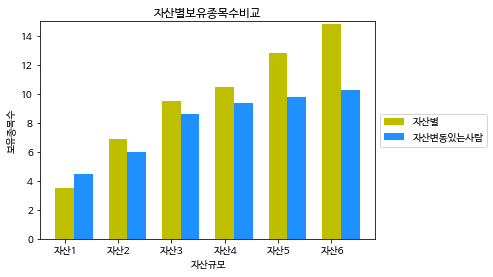

In [ ]:
자산 = ['자산1', '자산2', '자산3','자산4','자산5','자산6']
index = np.arange(6)
자산별보유종목수 = [자산1['월계좌'].mean(), 자산2['월계좌'].mean(), 자산3['월계좌'].mean(),자산4['월계좌'].mean(),자산5['월계좌'].mean(),자산6['월계좌'].mean()]
자산변동별보유종목수 = [자산변동1['월계좌'].mean(), 자산변동2['월계좌'].mean(), 자산변동3['월계좌'].mean(),자산변동4['월계좌'].mean(),자산변동5['월계좌'].mean(),자산변동6['월계좌'].mean()]
plt.title('자산별보유종목수비교')
bar_width= 0.35
plt.bar(index, 자산별보유종목수, bar_width, color='y',label = '자산별')
plt.bar(index+bar_width, 자산변동별보유종목수, bar_width, color='dodgerblue',  label = '자산변동있는사람')
plt.xticks(index, 자산)
plt.xlabel('자산규모')
plt.ylabel('보유종목수')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.ylim(0,15)


plt.show()

자산 크기에 따라서 평균적으로 보유종목 수가 늘어나는 것을 확인할 수 있었습니다. 하지만 자산변동있는 사람들의 보유종목 수는 자산이 늘어나는 것에 비해 크게 늘지 않았습니다. 또한 자산변동이 있는 사람의 자산1의 종목수가 자산별 합산했을 때 종목 수보다 큰 것이 특징인데, 이는 자산이 적을 때 미리 살 종목들을 사두고, 추후 자산이 늘어나면서 기존의 종목을 늘리는 투자를 했다고 해석해볼 수 있겠습니다. 하지만 데이터의 imbalance한 부분 때문에 이러한 결과가 나왔을 수도 있기에 추가적인 분석을 해보도록하겠습니다.

### 자산별 보유종목최고치 비교

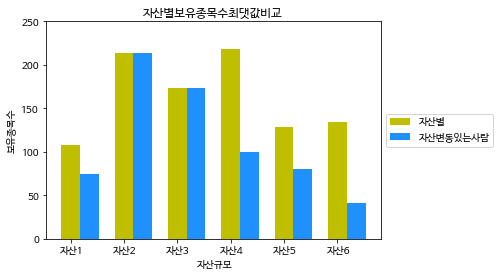

In [ ]:
자산 = ['자산1', '자산2', '자산3','자산4','자산5','자산6']
index = np.arange(6)
자산별보유종목수 = [자산1['월계좌'].max(), 자산2['월계좌'].max(), 자산3['월계좌'].max(),자산4['월계좌'].max(),자산5['월계좌'].max(),자산6['월계좌'].max()]
자산변동별보유종목수 = [자산변동1['월계좌'].max(), 자산변동2['월계좌'].max(), 자산변동3['월계좌'].max(),자산변동4['월계좌'].max(),자산변동5['월계좌'].max(),자산변동6['월계좌'].max()]
plt.title('자산별보유종목수최댓값비교')
bar_width= 0.35
plt.bar(index, 자산별보유종목수, bar_width, color='y',label = '자산별')
plt.bar(index+bar_width, 자산변동별보유종목수, bar_width, color='dodgerblue',  label = '자산변동있는사람')
plt.xticks(index, 자산)
plt.xlabel('자산규모')
plt.ylabel('보유종목수')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.ylim(0, 250)


plt.show()

자산이 많은 편인 자산4, 자산5, 자산6에서 최고보유종목수와 변동있는 사람의 최대보유종목수 차이가 많이 났습니다. 위에서는 평균으로 자산별보유종목수를 계산했었는데, 평균은 이상치, 최댓값 등에 영향을 많이 받는 변수이므로, 중앙값을 한번 확인해보도록하겠습니다.

### 자산별 보유종목중앙값 비교

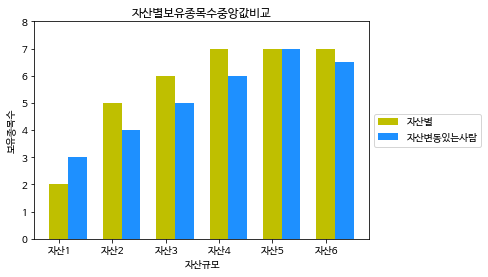

In [ ]:
자산 = ['자산1', '자산2', '자산3','자산4','자산5','자산6']
index = np.arange(6)
자산별보유종목수 = [자산1['월계좌'].median(), 자산2['월계좌'].median(), 자산3['월계좌'].median(),자산4['월계좌'].median(),자산5['월계좌'].median(),자산6['월계좌'].median()]
자산변동별보유종목수 = [자산변동1['월계좌'].median(), 자산변동2['월계좌'].median(), 자산변동3['월계좌'].median(),자산변동4['월계좌'].median(),자산변동5['월계좌'].median(),자산변동6['월계좌'].median()]
plt.title('자산별보유종목수중앙값비교')
bar_width= 0.35
plt.bar(index, 자산별보유종목수, bar_width, color='y',label = '자산별')
plt.bar(index+bar_width, 자산변동별보유종목수, bar_width, color='dodgerblue',  label = '자산변동있는사람')
plt.xticks(index, 자산)
plt.xlabel('자산규모')
plt.ylabel('보유종목수')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.ylim(0,8)


plt.show()

자산별중앙값과 자산변동있는 사람의 중앙값은 크게 차이나지 않았습니다. 또한 자산변동있는사람의 보유종목수 중앙값은 자산이 늘때마다 한개씩 늘어나는 양의 상관관계를 보입니다. 즉, 고객이 기존투자하던 자산에서 양을 늘리게 되면, 기존 종목의 비중도 늘리지만, 새로운 종목을 투자하는 경향도 강하다고 볼 수 있습니다. 이는 기본적으로 고객들이 분산투자에 대한 생각을 갖고 있다고 해석할 수 있습니다.  

### 자산별 계좌 수 비교

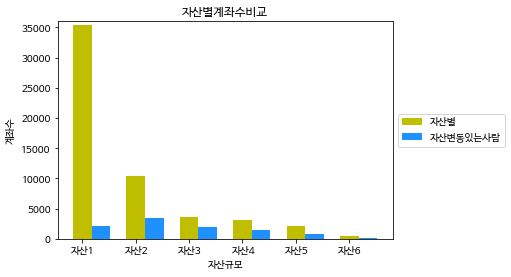

In [ ]:
자산 = ['자산1', '자산2', '자산3','자산4','자산5','자산6']
index = np.arange(6)
자산별보유종목수 = [자산1['월계좌'].value_counts().sum(), 자산2['월계좌'].value_counts().sum(), 자산3['월계좌'].value_counts().sum(),자산4['월계좌'].value_counts().sum(),자산5['월계좌'].value_counts().sum(),자산6['월계좌'].value_counts().sum()]
자산변동별보유종목수 = [자산변동1['월계좌'].value_counts().sum(), 자산변동2['월계좌'].value_counts().sum(), 자산변동3['월계좌'].value_counts().sum(),자산변동4['월계좌'].value_counts().sum(),자산변동5['월계좌'].value_counts().sum(),자산변동6['월계좌'].value_counts().sum()]
plt.title('자산별계좌수비교')
bar_width= 0.35
plt.bar(index, 자산별보유종목수, bar_width, color='y',label = '자산별')
plt.bar(index+bar_width, 자산변동별보유종목수, bar_width, color='dodgerblue',  label = '자산변동있는사람')
plt.xticks(index, 자산)
plt.xlabel('자산규모')
plt.ylabel('계좌수')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.ylim(0,36000)


plt.show()

자산별 계좌 수를 확인했을 때 한 가지 특이한 점을 발견했습니다.

*   총 계좌 중에서는 자산1(천만원 이하의 저자산고객군)이 차지하고 있는 고객이 압도적으로 많았는데, 자산변동있는고객 중에서는 오히려 자산2고객이 자산1고객보다 많았습니다. 또한 자산변동있는고객 중에서 전반적으로 고자산고객군들의 비중이 높았는데, 이는 고객들이 출금을 하기보다는 입금 등을 통해 투자자산을 늘리려 하는 경향이 큰 것을 알 수 있습니다.







특히 올해 1-6월달까지는 하락장이었기에, 보유종목의 평가금액이 올랐다기보다는 입금으로 인한 자산변동이라고 해석하는 것이 타당합니다.

### 자산, 매매종목수, 자산변동간의 상관성 분석 결과 종합
1. 자산이 늘어날 수록 매매종목수가 늘어납니다.
2. 투자하고 있던 고객이 투자금을 늘리면 기존보유 종목의 비중도 늘리지만, 투자종목 수도 같이 늘립니다.
3. 투자하고 있던 고객의 자산의 주요 변동 요인 중 하나가 입금입니다. 고객은 출금을 통해 투자자산을 줄이려하기보다는 입금을 통해 투자금액을 늘리는 경향이 큽니다.



위 분석 결과 종합을 통해 저희는 요즘 각광받고 있는 다이렉트 인덱싱 서비스 기획을 생각하게 되었습니다. 그 이유는 다음과 같습니다.
1. 위 분석 결과를 통해서 고객들이 자산을 늘리면 분산투자를
1. 다이렉트 인덱싱은 개인의 선호, 투자목적 등을 반영해 벤치마크 지수를 구성하고 이를 고객의 계좌 내에서 개별 종목 단위로 직접 운용하는 서비스입니다. 최근

## 2. 국내주식 자산별 거래종목 파악

고객정보를 통해 자산별 고객의 수를 구해줍니다.

In [ ]:
print(len(고객정보[고객정보['cus_aet_stn_cd'] == 1]))
print(len(고객정보[고객정보['cus_aet_stn_cd'] == 2]))
print(len(고객정보[고객정보['cus_aet_stn_cd'] == 3]))
print(len(고객정보[고객정보['cus_aet_stn_cd'] == 4]))
print(len(고객정보[고객정보['cus_aet_stn_cd'] == 5]))
print(len(고객정보[고객정보['cus_aet_stn_cd'] == 6]))
print(len(고객정보))

39313
10507
3601
3155
2046
459
59081


In [ ]:
자산분석1 = 국내주식거래분석[국내주식거래분석['고객자산구간코드']== 1] ## 천만원미만
자산분석2 = 국내주식거래분석[국내주식거래분석['고객자산구간코드']== 2] ## 천만원~3천만원
자산분석3 = 국내주식거래분석[국내주식거래분석['고객자산구간코드']== 3] ## 3천만원~5천만원
자산분석4 = 국내주식거래분석[국내주식거래분석['고객자산구간코드']== 4] ## 5천만원~1억원
자산분석5 = 국내주식거래분석[국내주식거래분석['고객자산구간코드']== 5] ## 1억원~3억원
자산분석6 = 국내주식거래분석[국내주식거래분석['고객자산구간코드']== 6] ## 3억원이상

print(len(국내주식거래분석[국내주식거래분석['고객자산구간코드']== 1]))## 천만원미만
print(len(국내주식거래분석[국내주식거래분석['고객자산구간코드']== 2])) ## 천만원~3천만원
print(len(국내주식거래분석[국내주식거래분석['고객자산구간코드']== 3])) ## 3천만원~5천만원
print(len(국내주식거래분석[국내주식거래분석['고객자산구간코드']== 4])) ## 5천만원~1억원
print(len(국내주식거래분석[국내주식거래분석['고객자산구간코드']== 5])) ## 1억원~3억원
print(len(국내주식거래분석[국내주식거래분석['고객자산구간코드']== 6])) ## 3억원이상
print(142905/39313)
print(80577/10507)
print(38323/3601)
print(36052/3155)
print(27649/2046)
print(7289/459)

142905
80577
38323
36052
27649
7289
3.635057105791977
7.668887408394403
10.642321577339628
11.426941362916006
13.513685239491691
15.880174291938998


월별 거래 또는 보유 빈도수는
1. 천만원 미만인 고객이 3.6회
2. 천만원~3천만원인 고객이 7.7회
3. 3천만원~5천만원인 고객이 10.6회
4. 5천만원~1억원인 고객이 11.4회
5. 1억원~3억원인 고객이 13.5회
6. 3억원이상인 고객이 15.9회입니다.

금액에 따라 고객의 거래빈도가 늘어나는 것을 확인할 수 있습니다. 아무래도 자산이 많을 수록 다양한 종목들을 많이 거래할 수 있겠죠. 그렇다면 자산별로 매매한 종목의 수 상위 20개를 구하고, 종목별 빈도수를 구한뒤 자산별 사람 수를 나눠서 상대적 빈도수까지 가늠할 수 있도록 분석해 보겠습니다.

### 자산별 거래종목 파악

In [ ]:
자산분석1종목 = 자산분석1['종목명'].value_counts()
자산분석1종목 = pd.DataFrame(자산분석1종목)
자산분석1종목.reset_index(inplace = True)
자산분석1종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
자산분석1종목['빈도비중'] = 자산분석1종목['종목빈도']/39313*100

자산분석2종목 = 자산분석2['종목명'].value_counts()
자산분석2종목 = pd.DataFrame(자산분석2종목)
자산분석2종목.reset_index(inplace = True)
자산분석2종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
자산분석2종목['빈도비중'] = 자산분석2종목['종목빈도']/10507*100

자산분석3종목 = 자산분석3['종목명'].value_counts()
자산분석3종목 = pd.DataFrame(자산분석3종목)
자산분석3종목.reset_index(inplace = True)
자산분석3종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
자산분석3종목['빈도비중'] = 자산분석3종목['종목빈도']/3601*100

자산분석4종목 = 자산분석4['종목명'].value_counts()
자산분석4종목 = pd.DataFrame(자산분석4종목)
자산분석4종목.reset_index(inplace = True)
자산분석4종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
자산분석4종목['빈도비중'] = 자산분석4종목['종목빈도']/3155*100

자산분석5종목 = 자산분석5['종목명'].value_counts()
자산분석5종목 = pd.DataFrame(자산분석5종목)
자산분석5종목.reset_index(inplace = True)
자산분석5종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
자산분석5종목['빈도비중'] = 자산분석5종목['종목빈도']/2046*100

자산분석6종목 = 자산분석6['종목명'].value_counts()
자산분석6종목 = pd.DataFrame(자산분석6종목)
자산분석6종목.reset_index(inplace = True)
자산분석6종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
자산분석6종목['빈도비중'] = 자산분석6종목['종목빈도']/459*100

print(자산분석1종목.head(20))
print(자산분석2종목.head(20))
print(자산분석3종목.head(20))
print(자산분석4종목.head(20))
print(자산분석5종목.head(20))
print(자산분석6종목.head(20))

          종목명   종목빈도       빈도비중
0        삼성전자  13478  34.283825
1         카카오   4535  11.535624
2       삼성전자우   2695   6.855239
3        대한항공   2160   5.494366
4        롯데렌탈   1657   4.214891
5         현대차   1539   3.914736
6      SK하이닉스   1384   3.520464
7         HMM   1227   3.121105
8       NAVER   1146   2.915066
9       카카오뱅크   1087   2.764989
10       비씨엔씨   1083   2.754814
11  SK바이오사이언스   1071   2.724290
12   에스디바이오센서   1007   2.561494
13       LG전자    914   2.324931
14    두산에너빌리티    898   2.284232
15     이지트로닉스    883   2.246076
16         기아    881   2.240989
17    LG디스플레이    817   2.078193
18       대한전선    755   1.920484
19       한국전력    693   1.762776
          종목명  종목빈도       빈도비중
0        삼성전자  5003  47.615875
1         카카오  2184  20.786143
2       삼성전자우  1199  11.411440
3         현대차  1018   9.688779
4       NAVER  1009   9.603122
5      SK하이닉스   943   8.974969
6        대한항공   904   8.603788
7         HMM   666   6.338631
8        LG전자   650   6.186352
9     두산에너빌리티   57

In [ ]:
# 공통종목 = [x for x in list(자산분석1종목['종목명'].head(20)) if x in list(자산분석2종목['종목명'].head(20))]
공통종목 = [x for x in list(자산분석2종목['종목명'].head(20)) if x in list(자산분석3종목['종목명'].head(20))]
공통종목 = [x for x in 공통종목 if x in list(자산분석4종목['종목명'].head(20))]
공통종목 = [x for x in 공통종목 if x in list(자산분석5종목['종목명'].head(20))]
공통종목 = [x for x in 공통종목 if x in list(자산분석6종목['종목명'].head(20))]
len(공통종목)

13


*   분석결과 자산별 매매종목 육안으로 보기에 자산그룹별로 큰 차이가 있지 않았습니다.
*   신규상장주가 몇 개 있는 1그룹을 제외한 나머지그룹의 공통종목을 확인한 결과 13개였습니다. 또한 13개 안에 들지 못했던 종목들도 거의 3-4개 그룹에서 공통으로 있는 종목들이라서 자산그룹별로 매매종목의 차이가 나지 않는다고 볼 수 있습니다.
*   자산의 차이가 투자 지식의 차이 또는 성향의 차이로 직결되지 않는다고 해석할 수 있겠습니다. 즉, 자산이 크다고 해서 수익률이 적지만 안전한 종목을 사는 경향이 있는 것은 아니고, 반대로 자산이 작다고 해서 고수익을 추구하는 성향이 있는 것은 아닌 것 같습니다.

전체적으로 사람들이 많이 사는 종목을 시각화해보겠습니다.





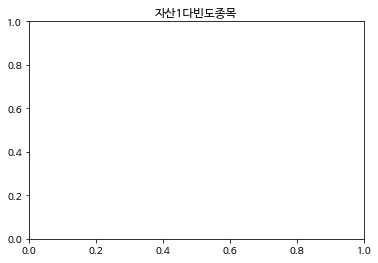

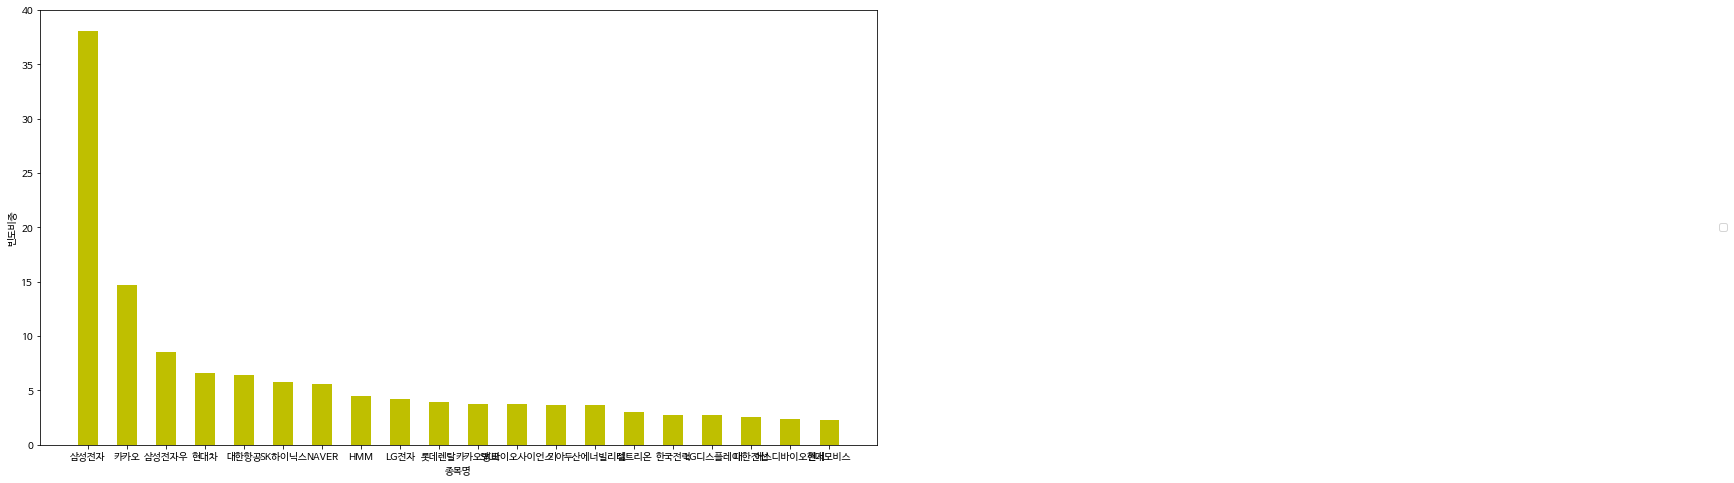

In [ ]:
국내주식거래분석종목 = 국내주식거래분석['종목명'].value_counts()
국내주식거래분석종목 = pd.DataFrame(국내주식거래분석종목)
국내주식거래분석종목.reset_index(inplace = True)
국내주식거래분석종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
국내주식거래분석종목['빈도비중'] = 국내주식거래분석종목['종목빈도']/59081*100

자산별다빈도종목 = list(국내주식거래분석종목.head(20)['종목명'])
index = np.arange(20)
자산별종목빈도 = list(국내주식거래분석종목.head(20)['빈도비중'])

plt.title('자산1다빈도종목')
plt.figure(figsize=(15,8))
bar_width= 0.5
plt.bar(index, 자산별종목빈도, bar_width, color='y')
plt.xticks(index, 자산별다빈도종목)
plt.xlabel('종목명')
plt.ylabel('빈도비중')
plt.legend(loc = 'center left', bbox_to_anchor = (2, 0.5))
plt.ylim(0,40)

plt.show()




*   삼성전자,카카오, 삼성전자우 등 대형주를 사람들이 많이 매매한 것을 알 수 있습니다.





하지만 위의 결과는 단순히 월별로 종목을 매매 또는 보유한 사람의 수를 합산한 것입니다. 만약 한주만 보유하고 있다고 하더라도 횟수에 포함되기 때문에 왜곡이 있을 수 있습니다. 비씨엔씨, 이지트로닉스 같은 신규상장주들이 천만원 이하 고객 거래/보유 빈도 수 상위 20위 안에 들 수 있던 이유였던 것 같습니다. 그래서 다음과 같은 분석을 해보도록 하겠습니다.
1. 보유 종목 중 자산 대비 비중이 18프로 이상인 종목을 기준으로 분석해보겠습니다.
2. 월별로 자산 대비 비중 5프로 이상 매수한 종목을 기준으로 분석해보겠습니다.

보유 종목 중 자산 대비 비중을 18프로로 정한 이유는 고객정보(59081)수를 잔고정보(332795)로 나눈 것이 17.8프로기 때문입니다. 매수매도는 반복적으로 이뤄지기 때문에 5프로 이상이면 충분히 의미가 있을 것이라고 생각했습니다.

### 자산 대비 비중 18프로인 종목파악

In [ ]:
비중분석 = 국내주식거래분석[국내주식거래분석['종목비중'] >= 18]
매수분석 = 국내주식거래분석[국내주식거래분석['매수금액비중'] >= 5]

자산비중분석1 = 비중분석[비중분석['고객자산구간코드']== 1] ## 천만원미만
자산비중분석2 = 비중분석[비중분석['고객자산구간코드']== 2] ## 천만원~3천만원
자산비중분석3 = 비중분석[비중분석['고객자산구간코드']== 3] ## 3천만원~5천만원
자산비중분석4 = 비중분석[비중분석['고객자산구간코드']== 4] ## 5천만원~1억원
자산비중분석5 = 비중분석[비중분석['고객자산구간코드']== 5] ## 1억원~3억원
자산비중분석6 = 비중분석[비중분석['고객자산구간코드']== 6] ## 3억원이상

자산비중분석1종목 = 자산비중분석1['종목명'].value_counts()
자산비중분석1종목 = pd.DataFrame(자산비중분석1종목)
자산비중분석1종목.reset_index(inplace = True)
자산비중분석1종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
자산비중분석1종목['빈도비중'] = 자산비중분석1종목['종목빈도']/39313*100

자산비중분석2종목 = 자산비중분석2['종목명'].value_counts()
자산비중분석2종목 = pd.DataFrame(자산비중분석2종목)
자산비중분석2종목.reset_index(inplace = True)
자산비중분석2종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
자산비중분석2종목['빈도비중'] = 자산비중분석2종목['종목빈도']/10507*100

자산비중분석3종목 = 자산비중분석3['종목명'].value_counts()
자산비중분석3종목 = pd.DataFrame(자산비중분석3종목)
자산비중분석3종목.reset_index(inplace = True)
자산비중분석3종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
자산비중분석3종목['빈도비중'] = 자산비중분석3종목['종목빈도']/3601*100

자산비중분석4종목 = 자산비중분석4['종목명'].value_counts()
자산비중분석4종목 = pd.DataFrame(자산비중분석4종목)
자산비중분석4종목.reset_index(inplace = True)
자산비중분석4종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
자산비중분석4종목['빈도비중'] = 자산비중분석4종목['종목빈도']/3155*100

자산비중분석5종목 = 자산비중분석5['종목명'].value_counts()
자산비중분석5종목 = pd.DataFrame(자산비중분석5종목)
자산비중분석5종목.reset_index(inplace = True)
자산비중분석5종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
자산비중분석5종목['빈도비중'] = 자산비중분석5종목['종목빈도']/2046*100

자산비중분석6종목 = 자산비중분석6['종목명'].value_counts()
자산비중분석6종목 = pd.DataFrame(자산비중분석6종목)
자산비중분석6종목.reset_index(inplace = True)
자산비중분석6종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
자산비중분석6종목['빈도비중'] = 자산비중분석6종목['종목빈도']/459*100

In [ ]:
print(자산비중분석1종목.head(20))
print(자산비중분석2종목.head(20))
print(자산비중분석3종목.head(20))
print(자산비중분석4종목.head(20))
print(자산비중분석5종목.head(20))
print(자산비중분석6종목.head(20))

           종목명   종목빈도       빈도비중
0         삼성전자  10415  26.492509
1          카카오   2250   5.723298
2        삼성전자우   1616   4.110600
3         롯데렌탈    874   2.223183
4         대한항공    749   1.905222
5          현대차    659   1.676290
6       SK하이닉스    543   1.381222
7        NAVER    536   1.363417
8    SK바이오사이언스    492   1.251494
9         크래프톤    458   1.165009
10    에스디바이오센서    441   1.121766
11         HMM    410   1.042912
12        LG전자    358   0.910640
13        셀트리온    299   0.760563
14       카카오뱅크    298   0.758019
15     두산에너빌리티    293   0.745301
16          기아    277   0.704602
17        비씨엔씨    253   0.643553
18  SK아이이테크놀로지    235   0.597767
19    다올인베스트먼트    224   0.569786
          종목명  종목빈도       빈도비중
0        삼성전자  2983  28.390597
1         카카오   689   6.557533
2       삼성전자우   507   4.825355
3         현대차   316   3.007519
4       NAVER   238   2.265157
5      SK하이닉스   227   2.160464
6        대한항공   172   1.637004
7     두산에너빌리티   166   1.579899
8        셀트리온   126   1.1992

보유비중이 높은 종목들을 분석한 결과는 다음과 같습니다.
1. 1000만원 미만의 자산 고객군의 보유비중이 높은 종목 상위 20개종목 중 신규상장주들의 비중이 높아졌습니다. 매수를 실제로 행한 종목들 상위 20개종목 중 이러한 신규상장주들이 없었기 때문에, 이는 청약으로 인한 영향으로 생각됩니다. 특히 2021년에는 대형신규상장주가 많은 해였기에 이들 주식 비중이 꽤 높은 것 같습니다.하지만 2021년 거래데이터는 없어서 그에 따른 분석은 못할 거 같습니다.

2. 1000만원 미만의 자산 고객군을 제외하면 보유비중이 높은 종목 상위 20개 종목들은 대부분 대형주로, 자산별 매매 종목과의 차이가 별로 없었습니다. 한가지 특이점은 전기차 etf가 있다는 점이 있고, 전기차 관련주들이 좀 더 많았다는 것입니다.

3. 자산별로도 매매하는 종목의 큰 차이가 있지 않았습니다. 고자산군에서 일부 특이한 종목이 있기도 하지만, 숫자가 너무 적어서(한명이 6달보유하면 6번 빈도수가 나오게 됩니다.) 큰 의미가 있다고 보긴 힘듭니다.

---
결국 실질적으로 의미있다고 생각되는 차이를 발견해내진 못하였습니다. 비중이 높은 종목들을 시각화해보고 빈도수가 높은 종목들과의 차이가 얼마나 있는지 알아보겠습니다.



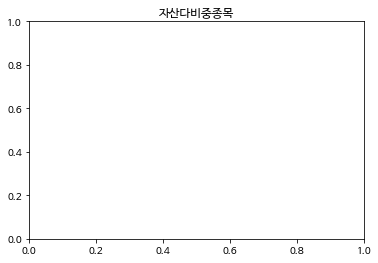

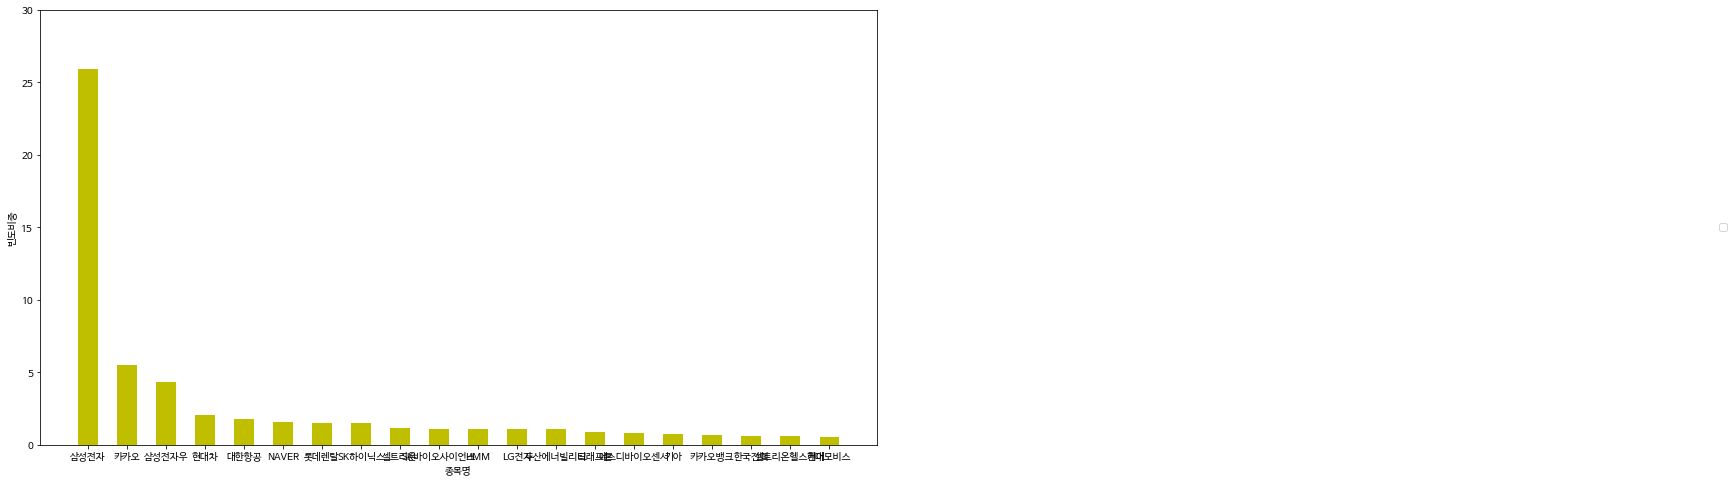

18


In [ ]:
비중분석종목 = 비중분석['종목명'].value_counts()
비중분석종목 = pd.DataFrame(비중분석종목)
비중분석종목.reset_index(inplace = True)
비중분석종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
비중분석종목['빈도비중'] = 비중분석종목['종목빈도']/59081*100

자산별다비중종목 = list(비중분석종목.head(20)['종목명'])
index = np.arange(20)
자산별비중빈도 = list(비중분석종목.head(20)['빈도비중'])

plt.title('자산다비중종목')
plt.figure(figsize=(15,8))
bar_width= 0.5
plt.bar(index, 자산별비중빈도, bar_width, color='y')
plt.xticks(index, 자산별다비중종목)
plt.xlabel('종목명')
plt.ylabel('빈도비중')
plt.legend(loc = 'center left', bbox_to_anchor = (2, 0.5))
plt.ylim(0,30)

plt.show()

공통종목1 = [x for x in 자산별다빈도종목 if x in 자산별다비중종목]
print(len(공통종목1))


다빈도거래종목과 다비중거래종목의 상위 20개 종목 중 18개가 동일했습니다. 즉 큰 차이가 있다고 보기에는 힘들 것 같습니다.

### 자산대비 5프로 이상 매수한 종목 파악

In [ ]:
자산매수분석1 = 매수분석[매수분석['고객자산구간코드']== 1] ## 천만원미만
자산매수분석2 = 매수분석[매수분석['고객자산구간코드']== 2] ## 천만원~3천만원
자산매수분석3 = 매수분석[매수분석['고객자산구간코드']== 3] ## 3천만원~5천만원
자산매수분석4 = 매수분석[매수분석['고객자산구간코드']== 4] ## 5천만원~1억원
자산매수분석5 = 매수분석[매수분석['고객자산구간코드']== 5] ## 1억원~3억원
자산매수분석6 = 매수분석[매수분석['고객자산구간코드']== 6] ## 3억원이상

자산매수분석1종목 = 자산매수분석1['종목명'].value_counts()
자산매수분석1종목 = pd.DataFrame(자산매수분석1종목)
자산매수분석1종목.reset_index(inplace = True)
자산매수분석1종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
자산매수분석1종목['빈도비중'] = 자산매수분석1종목['종목빈도']/39313*100

자산매수분석2종목 = 자산매수분석2['종목명'].value_counts()
자산매수분석2종목 = pd.DataFrame(자산매수분석2종목)
자산매수분석2종목.reset_index(inplace = True)
자산매수분석2종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
자산매수분석2종목['빈도비중'] = 자산매수분석2종목['종목빈도']/10507*100

자산매수분석3종목 = 자산매수분석3['종목명'].value_counts()
자산매수분석3종목 = pd.DataFrame(자산매수분석3종목)
자산매수분석3종목.reset_index(inplace = True)
자산매수분석3종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
자산매수분석3종목['빈도비중'] = 자산매수분석3종목['종목빈도']/3601*100

자산매수분석4종목 = 자산매수분석4['종목명'].value_counts()
자산매수분석4종목 = pd.DataFrame(자산매수분석4종목)
자산매수분석4종목.reset_index(inplace = True)
자산매수분석4종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
자산매수분석4종목['빈도비중'] = 자산매수분석4종목['종목빈도']/3155*100

자산매수분석5종목 = 자산매수분석5['종목명'].value_counts()
자산매수분석5종목 = pd.DataFrame(자산매수분석5종목)
자산매수분석5종목.reset_index(inplace = True)
자산매수분석5종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
자산매수분석5종목['빈도비중'] = 자산매수분석5종목['종목빈도']/2046*100

자산매수분석6종목 = 자산매수분석6['종목명'].value_counts()
자산매수분석6종목 = pd.DataFrame(자산매수분석6종목)
자산매수분석6종목.reset_index(inplace = True)
자산매수분석6종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
자산매수분석6종목['빈도비중'] = 자산매수분석6종목['종목빈도']/459*100

In [ ]:
print(자산매수분석1종목.head(20))
print(자산매수분석2종목.head(20))
print(자산매수분석3종목.head(20))
print(자산매수분석4종목.head(20))
print(자산매수분석5종목.head(20))
print(자산매수분석6종목.head(20))

         종목명  종목빈도      빈도비중
0       삼성전자  1769  4.499784
1        카카오   423  1.075980
2      삼성전자우   228  0.579961
3       휴림로봇   214  0.544349
4       한일사료   188  0.478213
5       팜스토리   176  0.447689
6       일동제약   172  0.437514
7      NAVER   161  0.409534
8    스마트솔루션즈   149  0.379009
9       대한전선   146  0.371378
10       HMM   145  0.368835
11   두산에너빌리티   144  0.366291
12      지에스이   137  0.348485
13    SK하이닉스   134  0.340854
14  LG에너지솔루션   133  0.338310
15      대한항공   126  0.320505
16     한국비엔씨   125  0.317961
17       현대차   124  0.315417
18       쌍방울   123  0.312874
19     카카오뱅크   111  0.282349
         종목명  종목빈도      빈도비중
0       삼성전자   571  5.434472
1        카카오   172  1.637004
2      NAVER   106  1.008851
3      삼성전자우    94  0.894642
4   LG에너지솔루션    91  0.866089
5       휴림로봇    81  0.770915
6       팜스토리    80  0.761397
7     SK하이닉스    80  0.761397
8        HMM    77  0.732845
9    스마트솔루션즈    76  0.723327
10   두산에너빌리티    73  0.694775
11      일동제약    73  0.694775
12      한일사료  

 의미있는 매수를 실제로 행한 종목들을 분석해본 결과 위에서 분석해서 나왔던 종목과의 차이가 확연히 드러났습니다. 또한 자산별로도 매매한 종목의 차이도 확연히 드러났습니다.
*    저자산군 집단에서는 고변동성의 주식을 많이 매매하였고, 고자산군 집단에서는
상대적으로 대형주들을 많이 매매하였는데, 특이점은 지수관련 etf가 상위 20개 종목안에 들어있다는 것이었습니다.
*   또한 저자산군에서 매매했던 종목들과 고자산군이 매매했던 종목군들이 꽤 많이 겹치는 것을 볼 수 있었습니다. 휴림로봇, 팜스토리, 일동제약 등의 종목은 테마주로 변동성이 큰 종목입니다. 고객이 매매한 종목을 분석해보면 고객의 특성을 알 수 있고 그에 따른 고객분류를 할 수 있다는 생각이 들었습니다.

---
다매수한 종목을 시각화해보고 고객들이 보유하고 있는 종목과 얼마나 다른지 비교해보도록하겠습니다.



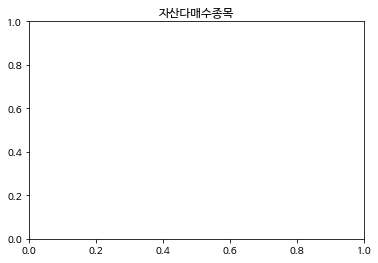

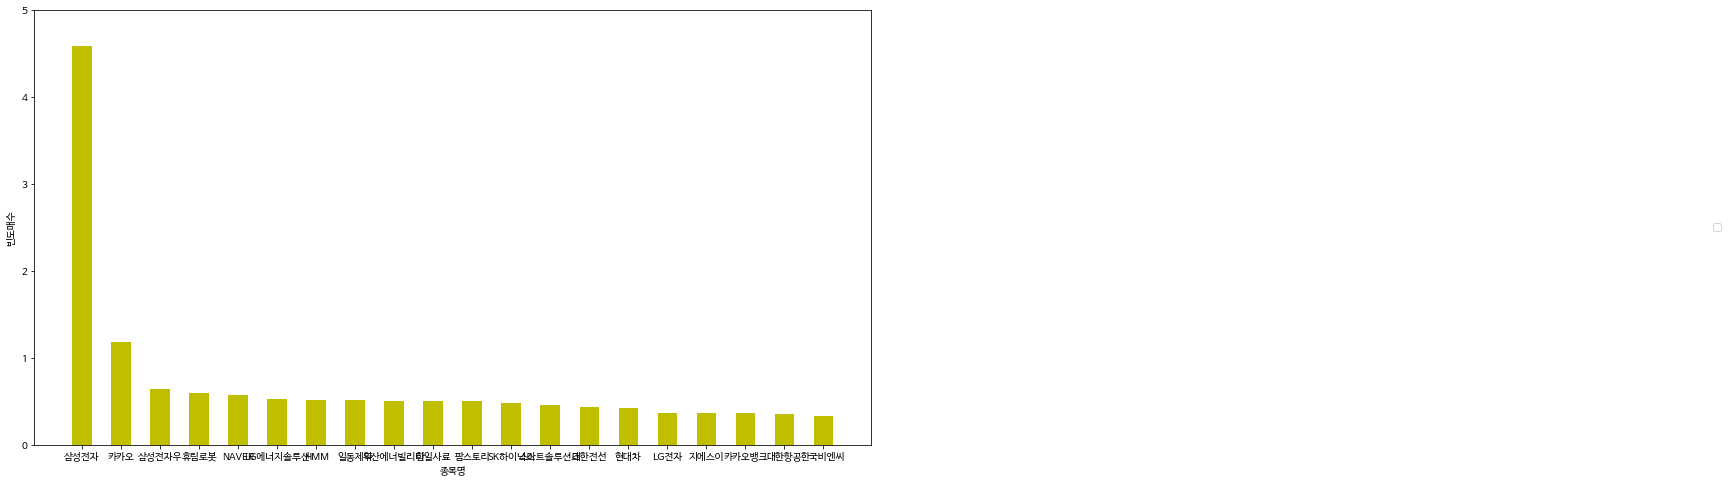

11


In [ ]:
매수분석종목 = 매수분석['종목명'].value_counts()
매수분석종목 = pd.DataFrame(매수분석종목)
매수분석종목.reset_index(inplace = True)
매수분석종목.rename(columns={'종목명':'종목빈도','index':'종목명'}, inplace = True)
매수분석종목['빈도매수'] = 매수분석종목['종목빈도']/59081*100

자산별다매수종목 = list(매수분석종목.head(20)['종목명'])
index = np.arange(20)
자산별매수빈도 = list(매수분석종목.head(20)['빈도매수'])

plt.title('자산다매수종목')
plt.figure(figsize=(15,8))
bar_width= 0.5
plt.bar(index, 자산별매수빈도, bar_width, color='y')
plt.xticks(index, 자산별다매수종목)
plt.xlabel('종목명')
plt.ylabel('빈도매수')
plt.legend(loc = 'center left', bbox_to_anchor = (2, 0.5))
plt.ylim(0,5)

plt.show()

공통종목2 = [x for x in 자산별다비중종목 if x in 자산별다매수종목]
print(len(공통종목2))

고객들이 많이 매수하는 종목들과 많이 보유한 종목들 중 공통된 종목은 11개였습니다. 고객들이 많이 보유한 종목들이 매매상위에 있기는 하지만 고객들이 장기 투자 대상으로 보는 종목과 단기 차익을 노리는 트레이딩 종목의 차이가 있다고 볼 수 있습니다.

## 자산과 매매종목 종류, 자산과 매매종목 수와의 연관관계 파악 총정리

자산별로 매매한 종목에 대해 분석해보았습니다. 여기서 얻을 수 있는 정보를 정리하면 다음과 같습니다.
1. 자산별로 보유한 종목의 차이는 미미하다.

2. 매수매도하는 종목과 보유종목의 차이는 확실히 드러난다.

**- 여기서 이후 분석의 힌트를 얻었습니다. trading하는 종목과 investing하는 종목이 다르다면, 각 종목들의 성격이 다른 것이므로, 종목마다 라벨링하여 고객들을 성향에 따라 분류해보고 그에 따른 분석을 해보면 의미있는 결과가 나오지 않을까 생각했습니다.**

3. 신규상장주 균등분배만을 이용하는 계좌가 있을 것이다.

-경쟁률 높은 신규상장주가 공모가보다 훨씬 높게 상장하는 것을 이용해 신규상장주만 매매하는 사람들도 꽤 있다고 알고 있습니다. 저자산 거래 상위에 신규상장주가 있어서 분석해보려고 합니다.

4. 고자산군에서는 ETF를 매매하는 고객이 꽤 있다.




위와 같은 분석 결과를 토대로 저희는 새로운 방향을 생각했습니다. 종목들을 종목의 성향에 따라 라벨링하고, 고객이 가장 많이 거래한 종목들의 라벨을 고객한테 적용하면, 고객거래데이터로 고객들을 거래성향에 따라 라벨링할 수 있다고 생각했습니다. 종목은 다음과 같이 라벨링하기로 하였습니다.
1. 대형주
2. 테마주(변동성이 높은 주식)
3. ETF
4. 기타주식
5. 신규상장주(단, 균등배분매매만 하는 경우에만.. 실질적으로 매수할 수도 있으므로)



업종별로 주식을 나누지 않고 위와 같이 주식을 나눈 이유는 다음과 같습니다.
1. 고객 데이터 수가 10000개인 것을 감안했을 때, 업종별로 주식을 구분하면 라벨이 너무 많아지게 된다고 생각했습니다. 또한 실질적으로 증권사에서 분류한 업종 내 주식이 반드시 비슷한 성격을 서로 갖고 있는 것도 아니기에 업종별로 주식을 나누지 않았습니다.
2. 대신에 외부주가 변동 데이터를 사용해 변동성이 높았던 주식을 라벨링하여 고위험 고수익을 추구하는 고객군들을 분류하려고 하였습니다.
3. 자산이 많아질수록 평균 매매종목수가 늘어나기에, 자동적으로 분산투자를 하는 효과를 누릴 수 있는 ETF에 대해서도 라벨링해봤습니다.
4. 신규상장주식이 매매상위에 올라와 있어서 균등배분매매하는 계좌들을 라벨링해보았습니다.

분석방법:
1. 분석의 편의를 위하여 거래데이터는 1월부터 6월달까지 모두 쓰고 보유종목을 분석하는 데이터는 6월데이터만 쓰려고 합니다.
2. 자산 대비 보유종목의 비중을 파악해서 어느정도의 비중을 갖고 있어야 해당 라벨을 붙일 수 있는지 정하려고 합니다.
3. 테마주 선정을 위해 1-6월 주가데이터를 가져오고 거기에서 변동성이 30%이상인 주식을 찾습니다.

## 해외주식데이터분석

해외주식 또한 라벨링 하기위해 분석을 하도록 하겠습니다. 해외주식에 대해 잘 알지 못하기에 6월 보유주식을 기준으로 간단하게 분석해보도록 하겠습니다.

해외주식은 종목코드를 찾기 힘들어서 고객 거래상위 50종목에서 대형주(시가총액 100억달러이상), 중소형주, ETF를 추출해서 분석해보고 방향성을 결정해보았습니다.

In [ ]:
해외주식보유분석 = 해외주식거래분석[해외주식거래분석['고객정보기준년월'] == '202206']
해외주식보유분석 = 해외주식보유분석[해외주식보유분석['종목비중'] != 0]
해외주식보유분석

,순매수금액,매수금액,매도금액,종목명,통합상품유형코드,결제기준통합잔고수량,통합매수체결수량,통합매도체결수량,체결기준통합잔고수량,결제기준현재평가금액,...,lifestage세그먼트코드,고객등급코드,총투자기간세그먼트코드,보유상품유형세그먼트코드,충성도세그먼트코드,주거래시장구분코드,주거래업종구분코드,자산기준주식거래유형코드,기본주식거래유형코드,월말자산
306267,0.000,0.000,0.0,CA50202P1053,15,40.0,0.0,0.0,40.0,346497.0,...,5,4,4,1.0,4.0,6.0,16.0,4.0,008,12422551.0
306269,0.000,0.000,0.0,US46222L1089,15,30.0,0.0,0.0,30.0,172990.0,...,5,4,4,1.0,4.0,6.0,16.0,4.0,008,12422551.0
306270,823040.000,823040.000,0.0,US88160R1014,15,3.0,0.0,0.0,3.0,2658732.0,...,5,4,4,1.0,4.0,6.0,16.0,4.0,008,12422551.0
306271,0.000,0.000,0.0,KYG651631007,15,100.0,0.0,0.0,100.0,606370.0,...,5,4,4,1.0,4.0,6.0,16.0,4.0,008,12422551.0
306273,0.000,0.000,0.0,US15961R1059,15,20.0,0.0,0.0,20.0,358391.0,...,5,4,4,1.0,4.0,6.0,16.0,4.0,008,12422551.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366642,0.000,0.000,0.0,US0636798235,15,68.0,0.0,0.0,68.0,2090671.0,...,1,9,3,1.0,5.0,6.0,16.0,5.0,010,2152918.0
366671,0.000,0.000,0.0,US6541101050,15,361.0,0.0,0.0,361.0,2202998.0,...,8,9,3,1.0,5.0,6.0,16.0,5.0,010,3130530.0
366734,0.000,0.000,0.0,US22266T1097,15,1.0,0.0,0.0,1.0,16781.0,...,4,5,1,1.0,5.0,6.0,16.0,4.0,010,5747653.0
366735,0.000,0.000,0.0,US68247W1099,15,1.0,0.0,0.0,1.0,5042.0,...,5,9,1,1.0,5.0,2.0,10.0,5.0,006,5042.0


In [ ]:
해외주식종목 = pd.DataFrame(해외주식보유분석['종목명'].value_counts())
해외주식종목.reset_index(inplace = True)
해외주식종목 = list(해외주식종목.head(50)['index'])

In [ ]:
미국ETF = ['US74347X8314', 'US46090E1038', 'US78462F1030', 'US25459W4583', 'US74347R2067', 'US00214Q1040']
미국중소형주 = ['US3743964062', 'US09075F1075', 'US46222L1089', 'US6541101050', 'US5006001011', 'CA86730L1094', 'US13803R1023', 'US83406F1021', 'US2826443010', 'US63008G2030', 'US35952H6018', 'US91332U1016', 'US92259F1012','US00165C1045', 'US03842K2006', 'US74374T1097']
미국대형주 =  [x for x in 해외주식종목 if x not in 미국ETF]
미국대형주 =  [x for x in 미국대형주 if x not in 미국중소형주]

### 해외종목 분류별 빈도수 시각화

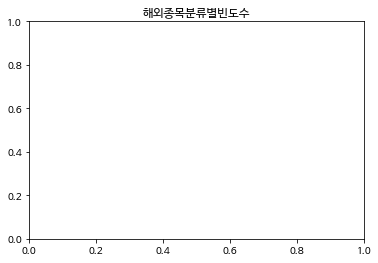

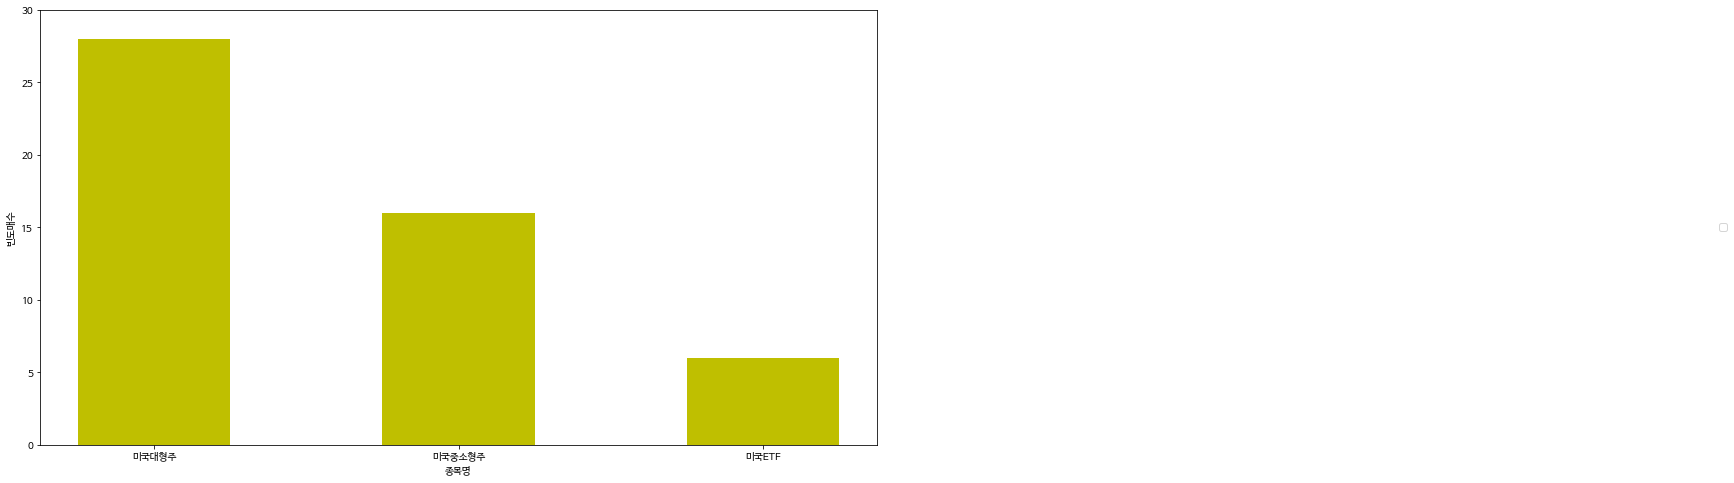

In [ ]:
해외종목분류 = ['미국대형주', '미국중소형주', '미국ETF']
index = np.arange(3)
해외종목분류별빈도수 = [len(미국대형주), len(미국중소형주),len(미국ETF)]

plt.title('해외종목분류별빈도수')
plt.figure(figsize=(15,8))
bar_width= 0.5
plt.bar(index, 해외종목분류별빈도수, bar_width, color='y')
plt.xticks(index, 해외종목분류)
plt.xlabel('종목명')
plt.ylabel('빈도매수')
plt.legend(loc = 'center left', bbox_to_anchor = (2, 0.5))
plt.ylim(0,30)

plt.show()

해외주식을 분석하기 전, 아무래도 해외주식정보를 접하기 힘들기 때문에 해외주식 거래 상위에는 구글, 엔비디아, 테슬라, 스타벅스, 디즈니, 쿠팡과 같은 친숙한 기업들처럼 대형주가 많을 것으로 예상했지만, 예상과 전혀 다른 결과가 나왔습니다.

1. 시가총액이 적은 기업들과, ETF도 많이 있었습니다. 상위 50개 종목 중 미국대형주가 차지하는 비중이 56프로밖에 안되어 한국주식 상위 종목과 매우 다른 양상을 보여줍니다.
2. 해외주식을 하는 사람들은 본인들이 정보를 찾아서 본인만의 투자전략을 적극적으로 구사한다고 생각할 수 있습니다.

해외주식투자자의 종목수와 투자성향에 대해서 알아보겠습니다.

### 국내주식보유자와 해외주식보유자의 종목수, 투자성향 시각화

In [ ]:
국내보유 = 국내주식거래분석[국내주식거래분석['고객정보기준년월'] == '202206']
국내보유 = 국내보유[국내보유['종목비중'] != 0]
국내고객수 = set(list(국내보유['계좌번호']))
해외고객수 = set(list(해외주식보유분석['계좌번호']))

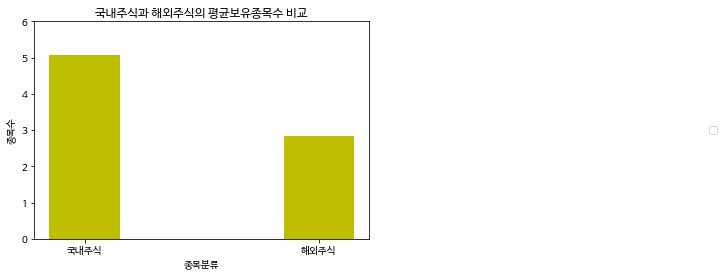

In [ ]:
종목분류 = ['국내주식', '해외주식']
index = np.arange(2)
평균보유종목수 = [len(국내보유)/len(국내고객수), len(해외주식보유분석)/len(해외고객수)]

plt.title('국내주식과 해외주식의 평균보유종목수 비교')

bar_width= 0.3
plt.bar(index, 평균보유종목수, bar_width, color='y')
plt.xticks(index, 종목분류)
plt.xlabel('종목분류')
plt.ylabel('종목수')
plt.legend(loc = 'center left', bbox_to_anchor = (2, 0.5))
plt.ylim(0,6)

plt.show()

In [ ]:
국내stockholder수 = 국내보유[국내보유['기본주식거래유형코드'] == '010']
해외stockholder수 = 해외주식보유분석[해외주식보유분석['기본주식거래유형코드'] == '010']

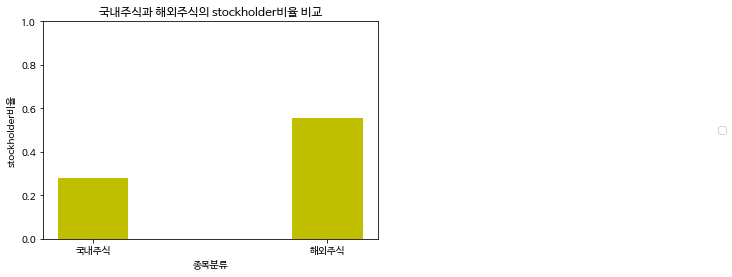

In [ ]:
종목분류 = ['국내주식', '해외주식']
index = np.arange(2)
stockholder비율 = [len(국내stockholder수)/len(국내보유), len(해외stockholder수)/len(해외주식보유분석)]

plt.title('국내주식과 해외주식의 stockholder비율 비교')

bar_width= 0.3
plt.bar(index, stockholder비율, bar_width, color='y')
plt.xticks(index, 종목분류)
plt.xlabel('종목분류')
plt.ylabel('stockholder비율')
plt.legend(loc = 'center left', bbox_to_anchor = (2, 0.5))
plt.ylim(0,1)

plt.show()

In [ ]:
국내stockholder수 = 국내보유[국내보유['기본주식거래유형코드'] == '010']
해외stockholder수 = 해외주식보유분석[해외주식보유분석['기본주식거래유형코드'] == '010']

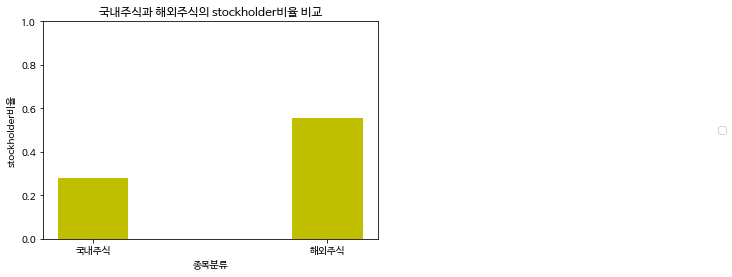

In [ ]:
종목분류 = ['국내주식', '해외주식']
index = np.arange(2)
stockholder비율 = [len(국내stockholder수)/len(국내보유), len(해외stockholder수)/len(해외주식보유분석)]

plt.title('국내주식과 해외주식의 stockholder비율 비교')

bar_width= 0.3
plt.bar(index, stockholder비율, bar_width, color='y')
plt.xticks(index, 종목분류)
plt.xlabel('종목분류')
plt.ylabel('stockholder비율')
plt.legend(loc = 'center left', bbox_to_anchor = (2, 0.5))
plt.ylim(0,1)

plt.show()

*   국내주식 평균 보유 종목수는 약 5개, 해외주식은 약 3개입니다.
*   국내주식투자자의 stockholder비율은 약 0.28이고 해외주식투자자의 stockholder비율은 약 0.55입니다.
즉, 국내주식투자자들에 비해 해외주식투자자들은 본인들이 정보를 적극적으로 찾아서 종목을 매수하고, 그에 따른 장기투자를 하는 성향을 보이고 있습니다. 그리고 해외주식투자자들이 주로 매매하는 주식이 미국주식인데, 미국주식시장 개장이 한국시간으로 밤에 하기 때문에 적극적으로 매매하기 힘들다고도 해석할 수 있겠습니다.


해외주식은 대형주, ETF, 중소형주(대형주, ETF 제외한 종목)으로 라벨링하도록하겠습니다.


# 데이터 전처리2
고객거래데이터를 통해서 파생변수를 만들고 해당 파생변수와 고객정보를 바탕으로 고객분류를 위한 군집분석을 시행하도록 하겠습니다.

## 대형주매매고객 라벨링, ETF 종목 불러오기

대형주는 코스피 시가총액 상위 50위 종목 전부 + 고객들이 매매를 많이한 상위 30위 종목 중에서 선별하여 정하였습니다. ETF는 api를 통해 불러왔던 종목을 이용하도록 하겠습니다.

대형주와 테마주 중 겹치는 종목은 대형주로 편입하도록 하겠습니다.

In [ ]:
대형주 = ['삼성전자','LG에너지솔루션','SK하이닉스','삼성바이오로직스','삼성전자우','LG화학','삼성SDI','현대차','기아','NAVER','셀트리온','카카오','삼성물산','POSCO홀딩스','현대모비스','KB금융','신한지주','SK','SK이노베이션','LG전자','삼성생명','포스코케미칼','한국전력','고려아연','LG','KT&G','하나금융지주','SK텔레콤','현대중공업','LG생활건강','S-OIL','크래프톤','두산에너빌리티','삼성화재','KT','한화솔루션','삼성에스디에스','HMM','삼성전기','카카오뱅크','우리금융지주','대한항공','엔씨소프트','기업은행','LG이노텍','아모레퍼시픽','현대글로비스','CJ제일제당','한국조선해양','F&F','SK아이이테크놀로지','셀트리온헬스케어','삼성중공업','LG디스플레이','카카오게임즈','SK바이오사이언스']
ETF = list(etf['종목'])


## 테마주를 고빈도매매하는 고객군들 라벨링

*   테마주를 변동성이 큰 주식으로 정의하도록 하겠습니다. 이러한 분류의 주식을 한달에 자금 대비 일정 비율 이상으로 매수한 고객군들을 테마주고빈도매매고객군들로 라벨링하도록 하겠습니다.

*   보유분석은 6월달 데이터만으로 하지만, 테마주 고빈도매매 고객은 6달 중 한번이라도 해당월 변동성이 컸던 주식을 자산 대비 40%이상 매수 한 이력이 있는 고객으로 선정하였습니다.


In [ ]:
다매매고객군 = 국내주식거래분석[(국내주식거래분석['기본주식거래유형코드'] == '001') |(국내주식거래분석['기본주식거래유형코드']== '002') | (국내주식거래분석['기본주식거래유형코드']== '003')]
다매매고객군매수 = 다매매고객군.groupby('월계좌')['매수금액비중'].sum()
다매매고객군매수 = pd.DataFrame(다매매고객군매수)


In [ ]:
다매매고객군매수['매수금액비중'].describe()

count    7090.000000
mean             inf
std              NaN
min         0.000000
25%        13.842870
50%        41.935208
75%       131.071528
max              inf
Name: 매수금액비중, dtype: float64

기본주식거래유형코드가 001,002,003까지는 주식시장 시세에 따른 매매를 하는 고객군들이라고 할 수 있습니다 이들 고객군들의 평균 계좌회전률을 구해서 해당 수치보다 살짝 낮은 수치 이상으로 거래하는(타종목군들도 거래할 수 있으므로) 고객군들을 테마주 고객군들로 정하도록 하겠습니다.

정말 스캘핑을 많이 하는 사람들은 계좌회전률이 어마무시하게 높으므로 전체 평균에 큰 영향을 끼칠 수 있어서 평균이 아닌 중위값을 사용하기로 결정하였습니다. 다매매고객군의 한달 계좌회전률 중위값은 41.9프로입니다. 그래서 테마주를 한달에 40프로 이상 매수한 고객군들을 테마주고빈도매매고객군으로 라벨링하도록 하겠습니다.

**종목 선정**

종가 기준으로 한달동안 고가와 저가의 변동성이 30프로가 넘었던 종목군들을 변동성 높은 종목(테마주)으로 선정하였습니다. 또한 시장 하락이 컸기 때문에 대형주들 중에서도 변동성이 컸던 종목들이 많았습니다. 대형주를 테마주에서는 제외시키도록 하겠습니다.

In [ ]:
코스피종목월봉['종목코드'] = 'A' + 코스피종목월봉['종목코드']
코스닥종목월봉['종목코드'] = 'A' + 코스닥종목월봉['종목코드']
코스피종목월봉 = 코스피종목월봉[~코스피종목월봉['종목명'].isin(대형주)]
코스닥종목월봉 = 코스닥종목월봉[~코스닥종목월봉['종목명'].isin(대형주)]


In [ ]:
변동종목1월코스피 = 코스피종목월봉[코스피종목월봉['연월'] == '2022/01']
변동종목1월코스피 = 변동종목1월코스피[변동종목1월코스피['최고가(종가)']/변동종목1월코스피['최저가(종가)'] >1.4]
변동종목1월코스닥 = 코스닥종목월봉[코스닥종목월봉['연월'] == '2022/01']
변동종목1월코스닥 = 변동종목1월코스닥[변동종목1월코스닥['최고가(종가)']/변동종목1월코스닥['최저가(종가)'] >1.4]

변동종목2월코스피 = 코스피종목월봉[코스피종목월봉['연월'] == '2022/02']
변동종목2월코스피 = 변동종목2월코스피[변동종목2월코스피['최고가(종가)']/변동종목2월코스피['최저가(종가)'] >1.3]
변동종목2월코스닥 = 코스닥종목월봉[코스닥종목월봉['연월'] == '2022/02']
변동종목2월코스닥 = 변동종목2월코스닥[변동종목2월코스닥['최고가(종가)']/변동종목2월코스닥['최저가(종가)'] >1.3]

변동종목3월코스피 = 코스피종목월봉[코스피종목월봉['연월'] == '2022/03']
변동종목3월코스피 = 변동종목3월코스피[변동종목3월코스피['최고가(종가)']/변동종목3월코스피['최저가(종가)'] >1.3]
변동종목3월코스닥 = 코스닥종목월봉[코스닥종목월봉['연월'] == '2022/03']
변동종목3월코스닥 = 변동종목3월코스닥[변동종목3월코스닥['최고가(종가)']/변동종목3월코스닥['최저가(종가)'] >1.3]

변동종목4월코스피 = 코스피종목월봉[코스피종목월봉['연월'] == '2022/04']
변동종목4월코스피 = 변동종목4월코스피[변동종목4월코스피['최고가(종가)']/변동종목4월코스피['최저가(종가)'] >1.3]
변동종목4월코스닥 = 코스닥종목월봉[코스닥종목월봉['연월'] == '2022/04']
변동종목4월코스닥 = 변동종목4월코스닥[변동종목4월코스닥['최고가(종가)']/변동종목4월코스닥['최저가(종가)'] >1.3]

변동종목5월코스피 = 코스피종목월봉[코스피종목월봉['연월'] == '2022/05']
변동종목5월코스피 = 변동종목5월코스피[변동종목5월코스피['최고가(종가)']/변동종목5월코스피['최저가(종가)'] >1.3]
변동종목5월코스닥 = 코스닥종목월봉[코스닥종목월봉['연월'] == '2022/05']
변동종목5월코스닥 = 변동종목5월코스닥[변동종목5월코스닥['최고가(종가)']/변동종목5월코스닥['최저가(종가)'] >1.3]

변동종목6월코스피 = 코스피종목월봉[코스피종목월봉['연월'] == '2022/06']
변동종목6월코스피 = 변동종목6월코스피[변동종목6월코스피['최고가(종가)']/변동종목6월코스피['최저가(종가)'] >1.4]
변동종목6월코스닥 = 코스닥종목월봉[코스닥종목월봉['연월'] == '2022/06']
변동종목6월코스닥 = 변동종목6월코스닥[변동종목6월코스닥['최고가(종가)']/변동종목6월코스닥['최저가(종가)'] >1.5]


종목선정을 할 때 1월,6월같은 경우는 지수하락폭이 매우 컸기 때문에 40프로의 변동성을 보여주는 종목군으로 선정을 하였습니다.(6월 코스닥은 50프로) 또한 이렇게 종목선정을 하면 원래 의도였던 많이 올라가는 변동성을 보여주는 종목을 선별하는 것뿐만 아니라 많이 하락하는 종목군들도 많이 선별되기 때문에 좋은 방식은 아니지만, 저희가 무료로 수집할 수 있는 데이터의 한계가 있었기 때문에 궁여지책으로 하였습니다. 하지만 하락폭이 큰 종목들 또한 대다수가 테마주 또는 다른 주식들보다 위험한 종목군들이기 때문에, 이러한 종목들을 장기투자하는 고객들 또한 비슷한 성향일 것으로 생각되어 그대로 분석을 진행하도록 하겠습니다.

In [ ]:
변동종목1월 = pd.concat([변동종목1월코스피,변동종목1월코스닥])
변동종목2월 = pd.concat([변동종목2월코스피,변동종목2월코스닥])
변동종목3월 = pd.concat([변동종목3월코스피,변동종목3월코스닥])
변동종목4월 = pd.concat([변동종목4월코스피,변동종목4월코스닥])
변동종목5월 = pd.concat([변동종목5월코스피,변동종목5월코스닥])
변동종목6월 = pd.concat([변동종목6월코스피,변동종목6월코스닥])

테마주 = list(변동종목1월['종목명']) +list(변동종목2월['종목명'])+ list(변동종목3월['종목명'])+ list(변동종목4월['종목명'])+ list(변동종목5월['종목명'])+list(변동종목6월['종목명'])
테마주 = set(테마주)
테마주 = list(테마주)

변동1월종목 = list(변동종목1월['종목코드'])
변동2월종목 = list(변동종목2월['종목코드'])
변동3월종목 = list(변동종목3월['종목코드'])
변동4월종목 = list(변동종목4월['종목코드'])
변동5월종목 = list(변동종목5월['종목코드'])
변동6월종목 = list(변동종목6월['종목코드'])

변동1월 = 국내주식거래분석[국내주식거래분석['고객정보기준년월'] == '202201']
변동2월 = 국내주식거래분석[국내주식거래분석['고객정보기준년월'] == '202202']
변동3월 = 국내주식거래분석[국내주식거래분석['고객정보기준년월'] == '202203']
변동4월 = 국내주식거래분석[국내주식거래분석['고객정보기준년월'] == '202204']
변동5월 = 국내주식거래분석[국내주식거래분석['고객정보기준년월'] == '202205']
변동6월 = 국내주식거래분석[국내주식거래분석['고객정보기준년월'] == '202206']

변동1월분석 = 변동1월[변동1월['종목코드'].isin(변동1월종목)]
변동1월분석 = pd.DataFrame(변동1월분석.groupby('계좌번호')['매수금액비중'].sum())
변동1월분석 = 변동1월분석[변동1월분석['매수금액비중']>40]

변동2월분석 = 변동2월[변동2월['종목코드'].isin(변동1월종목)]
변동2월분석 = pd.DataFrame(변동2월분석.groupby('계좌번호')['매수금액비중'].sum())
변동2월분석 = 변동2월분석[변동2월분석['매수금액비중']>40]

변동3월분석 = 변동3월[변동3월['종목코드'].isin(변동1월종목)]
변동3월분석 = pd.DataFrame(변동3월분석.groupby('계좌번호')['매수금액비중'].sum())
변동3월분석 = 변동3월분석[변동3월분석['매수금액비중']>40]

변동4월분석 = 변동4월[변동4월['종목코드'].isin(변동1월종목)]
변동4월분석 = pd.DataFrame(변동4월분석.groupby('계좌번호')['매수금액비중'].sum())
변동4월분석 = 변동4월분석[변동4월분석['매수금액비중']>40]

변동5월분석 = 변동5월[변동5월['종목코드'].isin(변동1월종목)]
변동5월분석 = pd.DataFrame(변동5월분석.groupby('계좌번호')['매수금액비중'].sum())
변동5월분석 = 변동5월분석[변동5월분석['매수금액비중']>40]

변동6월분석 = 변동6월[변동6월['종목코드'].isin(변동6월종목)]
변동6월분석 = pd.DataFrame(변동6월분석.groupby('계좌번호')['매수금액비중'].sum())
변동6월분석 = 변동6월분석[변동6월분석['매수금액비중']>40]

테마주고빈도매매고객 = list(변동1월분석.index) +list(변동2월분석.index) + list(변동3월분석.index) + list(변동4월분석.index) + list(변동5월분석.index) + list(변동6월분석.index)
테마주고빈도매매고객 = set(테마주고빈도매매고객)

len(테마주고빈도매매고객)

861

## 신규상장종목균등배정매매 고객군 라벨링

신규상장종목만 균등배정 받는 사람들의 특징을 생각해보았습니다.
1. 월말자산은 적을 것입니다.
2. 잔고수량과 매수한 기록이 없을 것입니다.
3. 다른 종목에 투자한 비중이 없을 것입니다.

이 세가지 조건에 해당하는 계좌는 신규상장계좌로 하려고 합니다. 사실 2021년 신규상장주식이 보유상위종목에 올라와있어서 분석하면 더 좋았겠지만(빈도수가 많기도 하고 대형주식도 많아서), 데이터가 없기에 2022년 신규상장종목에 대해서만 분석하도록하겠습니다.

In [ ]:
신규상장종목들 = list(신규상장종목['회사명'])
투자비중 = pd.DataFrame(국내주식거래분석.groupby('월계좌')['종목비중'].sum())
투자비중.reset_index(inplace = True)
투자비중.rename(columns = {'종목비중':'투자비중'}, inplace= True)
국내주식거래분석 = pd.merge(국내주식거래분석,투자비중)
신규상장종목분석 = 국내주식거래분석[국내주식거래분석['종목명'].isin(신규상장종목들)].dropna(axis=0)
신규상장종목분석 = 신규상장종목분석[신규상장종목분석['월말자산'] <= 1000000]
신규상장종목분석 = 신규상장종목분석[신규상장종목분석['체결기준통합잔고수량'] == 0]
신규상장종목분석 = 신규상장종목분석[신규상장종목분석['매수금액'] == 0]
신규상장종목분석 = 신규상장종목분석[신규상장종목분석['투자비중'] == 0]
신규상장매매고객 = set(신규상장종목분석['계좌번호'])
len(신규상장매매고객)

269

## 국내주식라벨링

우선 대형주, 테마주, ETF , 기타종목을 라벨링하도록 하겠습니다. 또한 그 후 해외주식에 관해서도 라벨링하고 종목비율을 따져서 최종적으로 고객별로 라벨링하려고 합니다.

In [ ]:
국내주식보유분석 = 국내주식거래분석[국내주식거래분석['고객정보기준년월'] =='202206']
국내주식보유분석 = 국내주식보유분석[국내주식거래분석['종목비중'] != 0]
해외주식보유분석 = 해외주식거래분석[해외주식거래분석['고객정보기준년월'] == '202206']
해외주식보유분석 = 해외주식보유분석[해외주식거래분석['종목비중'] != 0]


국내주식라벨링

In [ ]:
국내주식보유분석2 = 국내주식보유분석[국내주식보유분석['종목명'].isin(테마주)]
국내주식보유분석2['종목분류'] = '2'
국내주식보유분석1 = 국내주식보유분석[국내주식보유분석['종목명'].isin(대형주)]
국내주식보유분석1['종목분류'] = '1'
국내주식보유분석3 = 국내주식보유분석[국내주식보유분석['종목명'].isin(ETF)]
국내주식보유분석3['종목분류'] = '3'
국내주식보유분석4 = 국내주식보유분석[~국내주식보유분석['종목명'].isin(테마주)]
국내주식보유분석4 = 국내주식보유분석4[~국내주식보유분석['종목명'].isin(대형주)]
국내주식보유분석4 = 국내주식보유분석4[~국내주식보유분석['종목명'].isin(ETF)]
국내주식보유분석4['종목분류'] = '4'
국내주식보유분석 = pd.concat([국내주식보유분석1, 국내주식보유분석2, 국내주식보유분석3, 국내주식보유분석4])



In [ ]:
국내주식거래분석6월1 = 국내주식거래분석6월[국내주식거래분석6월['종목명'].isin(대형주)]
국내주식거래분석6월1['종목분류'] = '1'
국내주식거래분석6월2 = 국내주식거래분석6월[국내주식거래분석6월['종목코드'].isin(변동6월종목)]
국내주식거래분석6월2['종목분류'] = '2'
국내주식거래분석6월3 = 국내주식거래분석6월[국내주식거래분석6월['종목명'].isin(ETF)]
국내주식거래분석6월3['종목분류'] = '3'
국내주식거래분석6월4 = 국내주식거래분석6월[~국내주식거래분석6월['종목코드'].isin(변동6월종목)]
국내주식거래분석6월4 = 국내주식거래분석6월4[~국내주식거래분석6월['종목명'].isin(대형주)]
국내주식거래분석6월4 = 국내주식거래분석6월4[~국내주식거래분석6월['종목명'].isin(ETF)]
국내주식거래분석6월4['종목분류'] = '4'
국내주식거래분석6월 = pd.concat([국내주식거래분석6월1, 국내주식거래분석6월2, 국내주식거래분석6월3, 국내주식거래분석6월4])

In [ ]:
국내주식보유분석['종목분류']

278012    1
278014    1
278021    1
278022    1
278025    1
         ..
332759    4
332765    4
332766    4
332777    4
332786    4
Name: 종목분류, Length: 44441, dtype: object

##해외주식라벨링

In [ ]:
해외주식보유분석1 = 해외주식보유분석[해외주식보유분석['종목명'].isin(미국대형주)]
해외주식보유분석1['종목분류'] = '6'
해외주식보유분석2 = 해외주식보유분석[해외주식보유분석['종목명'].isin(미국ETF)]
해외주식보유분석2['종목분류'] = '7'
해외주식보유분석3 = 해외주식보유분석[~해외주식보유분석['종목명'].isin(미국대형주)]
해외주식보유분석3 = 해외주식보유분석3[~해외주식보유분석['종목명'].isin(미국ETF)]
해외주식보유분석3['종목분류'] = '8'
해외주식보유분석 = pd.concat([해외주식보유분석1, 해외주식보유분석2, 해외주식보유분석3])

##보유주식비중에 따른 고객라벨링

0. 해당사항없음(비매매고객)..0으로 라벨링(결측치)
1. 국내대형주
2. 테마주
3. 국내ETF
4. 국내중소형주
5. 신규상장주
6. 해외대형주
7. 해외ETF
8. 해외중소형주


이런 식으로 해당 부류의 종목비중이 가장 높은 것으로 고객별로 라벨링하도록 하겠습니다. 여기에 추가적으로 추후 군집분석 시 의미 있을 만한 파생변수로 계좌마다의

1.보유 종목갯수를 합산한 파생변수
2.총투자비중
3.테마주고빈도매매자

3개의 파생변수를 생성하도록 하겠습니다.

In [ ]:
국내주식보유분석 = 국내주식보유분석.drop(['종목코드'], axis=1)
주식보유분석 = pd.concat([해외주식보유분석, 국내주식보유분석]) ##해외주식과 국내주식 데이터프레임 합쳐서 분석하기
종목분류 = pd.DataFrame(주식보유분석.groupby(['계좌번호','종목분류'])['종목비중'].sum())
종목분류.reset_index(level=['계좌번호','종목분류'], inplace = True)
종목분류

,계좌번호,종목분류,종목비중
0,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,4,2.028015
1,00086aa946369d1c75182dffd43bd4a34f3abc1ddeba03...,2,89.330298
2,0013250ee6bc012ce49a9eae6929a65cf50a1844c564de...,2,23.064406
3,002f84a03e2b6300db16322799882cc6b7201022b62fc9...,2,100.000000
4,0036c57441034bbb6b5a9618d3ff6a1ec9734b78327c7e...,1,18.492938
...,...,...,...
19131,ffc0e6b3eaf8b59f8c471e4d6d68063106dc5bd2414ca5...,4,18.396275
19132,ffce5f2a556e2192467333e9d9e2e141daa83f78eea428...,1,90.417287
19133,ffd96d859770d62800f6f654fce913c50f9cbf809efcc8...,1,100.000000
19134,ffdb8a101b04d93c8b09ddce17a7be84d0179908f3f4cc...,2,99.142643


In [ ]:
a= 종목분류.groupby(['계좌번호']).max('종목비중')
a.reset_index(level=['계좌번호'], inplace = True)
a['종목비중'] = a['종목비중'].astype('str')
종목분류['종목비중'] =종목분류['종목비중'].astype('str')
a['공통'] = a['계좌번호'] + a['종목비중']
종목분류['공통'] = 종목분류['계좌번호'] + 종목분류['종목비중']
종목분류 = 종목분류.drop_duplicates(['공통'], keep ='first') ## 공통항이 생긴이유는 서로 비중이 높은 종목분류에서 같은 것이 있어서 그런 것 같음
종목분류 = pd.merge(a, 종목분류, on ='공통', how = 'left')
종목분류 = 종목분류[['계좌번호_x','종목분류']]
종목분류 = 종목분류.rename(columns = {'계좌번호_x':'계좌번호','종목분류':'고객분류'})
종목분류

,계좌번호,고객분류
0,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,4
1,00086aa946369d1c75182dffd43bd4a34f3abc1ddeba03...,2
2,0013250ee6bc012ce49a9eae6929a65cf50a1844c564de...,2
3,002f84a03e2b6300db16322799882cc6b7201022b62fc9...,2
4,0036c57441034bbb6b5a9618d3ff6a1ec9734b78327c7e...,4
...,...,...
9398,ffc0e6b3eaf8b59f8c471e4d6d68063106dc5bd2414ca5...,1
9399,ffce5f2a556e2192467333e9d9e2e141daa83f78eea428...,1
9400,ffd96d859770d62800f6f654fce913c50f9cbf809efcc8...,1
9401,ffdb8a101b04d93c8b09ddce17a7be84d0179908f3f4cc...,2


In [ ]:
종목분류

,계좌번호,고객분류
0,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,4
1,00086aa946369d1c75182dffd43bd4a34f3abc1ddeba03...,2
2,0013250ee6bc012ce49a9eae6929a65cf50a1844c564de...,2
3,002f84a03e2b6300db16322799882cc6b7201022b62fc9...,2
4,0036c57441034bbb6b5a9618d3ff6a1ec9734b78327c7e...,4
...,...,...
9398,ffc0e6b3eaf8b59f8c471e4d6d68063106dc5bd2414ca5...,1
9399,ffce5f2a556e2192467333e9d9e2e141daa83f78eea428...,1
9400,ffd96d859770d62800f6f654fce913c50f9cbf809efcc8...,1
9401,ffdb8a101b04d93c8b09ddce17a7be84d0179908f3f4cc...,2


In [ ]:
보유종목수분석6월 = pd.DataFrame(주식거래분석6월['계좌번호'].value_counts())
보유종목수분석6월.reset_index(inplace = True)
보유종목수분석6월 = 보유종목수분석6월.rename(columns = {'index':'계좌번호','계좌번호':'종목수'})
투자비중분석6월 = pd.DataFrame(주식거래분석6월.groupby('계좌번호')['종목비중'].sum())
투자비중분석6월.reset_index(inplace = True)
투자비중분석6월 = 투자비중분석6월.rename(columns = {'종목비중':'투자비중'})

In [ ]:
투자비중분석1월 = pd.DataFrame(주식보유분석.groupby('계좌번호')['종목비중'].sum())
투자비중분석1월.reset_index(inplace = True)
투자비중분석1월 = 투자비중분석.rename(columns = {'종목비중':'투자비중'})

## 분석대상 고객정보테이블 만들기
이제 고객거래데이터를 기반으로 형성한 파생변수를 고객정보 데이터프레임에 붙여주고 고객분류를 위한 데이터 전처리를 마무리하도록하겠습니다.

In [ ]:
고객정보분석대상 = 고객정보[고객정보['bse_ym'] == '202206']
고객정보분석대상.rename(columns ={'cus_no':'고객번호', 'act_no':'계좌번호', 'bse_ym':'고객정보기준년월', 'mts_mm_access_type':'MTS월단위접속패턴', 'sex_dit_cd':'성별',
       'cus_age_stn_cd':'연령대', 'cus_aet_stn_cd':'고객자산구간코드', 'pft_amt_stn_cd':'수익금액구간코드', 'fst_act_opn_dt':'최초계좌개설일',
       'stk_pdt_hld_yn':'주식상품보유여부', 'ose_stk_pdt_hld_yn':'해외주식상품보유여부', 'mrz_pdt_tp_sgm_cd':'주거래상품군',
       'lsg_sgm_cd':'lifestage세그먼트코드', 'tco_cus_grd_cd':'고객등급코드', 'tot_ivs_te_sgm_cd':'총투자기간세그먼트코드',
       'hld_pdt_tp_sgm_cd':'보유상품유형세그먼트코드', 'loy_sgm_cd':'충성도세그먼트코드', 'mrz_mkt_dit_cd':'주거래시장구분코드', 'mrz_btp_dit_cd':'주거래업종구분코드',
       'aet_bse_stk_trd_tp_cd':'자산기준주식거래유형코드', 'bas_stk_trd_tp_cd':'기본주식거래유형코드'}, inplace = True)
고객정보분석대상.drop(columns = {'월계좌','월말자산'},inplace = True)

In [ ]:
고객정보분석대상 = pd.merge(고객정보분석대상, 종목분류, on = '계좌번호', how = 'left')
고객정보분석대상 = pd.merge(고객정보분석대상, 투자비중분석, on = '계좌번호', how = 'left')
고객정보분석대상 = pd.merge(고객정보분석대상, 보유종목수분석, on = '계좌번호', how = 'left')
# 고객정보분석대상.loc[고객정보분석대상['계좌번호'].isin(테마주고빈도매매고객),'테마주고빈도매매코드'] = '1'
# 고객정보분석대상.loc[고객정보분석대상['계좌번호'].isin(신규상장매매고객),'고객분류'] = '5'
고객정보분석대상 = 고객정보분석대상.fillna(0)
고객정보분석대상['투자비중']= np.digitize(고객정보분석대상['투자비중'], bins=[0,30,60,70,80,90]) ##구간화.. 범주형 변수
고객정보분석대상['종목수']= np.digitize(고객정보분석대상['종목수'], bins=[1,4,7,11,16,21,31]) ##구간화.. 범주형 변수
# 고객정보분석대상['계좌번호'].isin(신규상장매매고객)

In [ ]:
고객정보분석대상

,고객번호,계좌번호,고객정보기준년월,MTS월단위접속패턴,성별,연령대,고객자산구간코드,수익금액구간코드,최초계좌개설일,주식상품보유여부,...,보유상품유형세그먼트코드,충성도세그먼트코드,주거래시장구분코드,주거래업종구분코드,자산기준주식거래유형코드,기본주식거래유형코드,고객분류,투자비중,종목수,테마주고빈도매매코드
0,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202206,111111,1,4,1,1,20050309,Y,...,1.0,4.0,6.0,16.0,5.0,009,1,6,3,0
1,3072d776c716010235dd75b3195d760bf3c46e00deee4e...,afa2e6df88371acd0768c15a14aebf9e81ed131af729e3...,202206,111111,1,7,1,1,20091013,Y,...,1.0,4.0,6.0,16.0,5.0,008,1,6,1,0
2,dc6eb520d8a2ca7fcc5e95aef37120b8b1d91a3d30bd7e...,726a3295019efd88142038b123013623e26a217d2b08df...,202206,110000,1,5,1,1,20110914,Y,...,1.0,5.0,6.0,16.0,5.0,010,2,4,1,0
3,d11e0b4608537bc4cf260a2af2d5e04f0a1c58219c5008...,4f2a78f9a162f9c82350f40627ce1062afaefeb4ff34e7...,202206,1111,1,6,5,1,20150915,Y,...,1.0,3.0,6.0,16.0,3.0,008,2,6,1,0
4,a93943ad4a16323cd7ffb6efb3f52fe566139304ec6bde...,8010d50edbbcd1974e12cb20fbca3a3abea0088df3070e...,202206,111100,2,4,1,1,20151005,Y,...,1.0,5.0,6.0,16.0,5.0,010,5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,ce1052f9cbcde0c946012223d8e75a8c450b446dbf94f1...,331ebc85b76813b4f37ace30577786f061df9b5a559644...,202206,1,1,8,1,1,20210424,Y,...,1.0,5.0,6.0,16.0,5.0,010,4,6,1,0
9996,bd56add752a126362d7a469c73cdd577409bbbbf567c15...,7cb8cdf0bdc909cafe3b4522c8afe86c3bae8acc81a31e...,202206,110000,1,2,1,1,20210425,Y,...,1.0,5.0,6.0,16.0,5.0,010,2,4,1,0
9997,94f7caefe90ce173f26d077084b7a337bb0d84c198a91e...,e6d3e46bc3a679c2ac46811862787bbfda4fa59acc013d...,202206,111111,2,3,1,1,20210616,Y,...,1.0,4.0,6.0,16.0,4.0,008,1,6,3,1
9998,2be1d24c654b9730408b82716d21fb5ec27377dd3b5ca3...,3fb721c5a808e4e848adebcf80cb1c9badff6382033b45...,202206,111011,2,5,1,1,20210707,Y,...,1.0,5.0,6.0,16.0,5.0,010,2,5,1,0


이로써 데이터 전처리과정을 모두 끝냈습니다. 이제 거래데이터를 기반으로 한 파생변수와 고객정보를 바탕으로 군집분석을 시행해보도록하겠습니다.

In [ ]:
# 추가 분석을 진행하기 전, 만들어진 데이터를 저장해줍니다.
고객정보분석대상.to_csv('./고객정보분석대상.csv')

In [ ]:
고객정보6월 = 고객정보[고객정보['bse_ym'] == '202206']
고객정보6월.rename(columns ={'cus_no':'고객번호', 'act_no':'계좌번호', 'bse_ym':'고객정보기준년월', 'mts_mm_access_type':'MTS월단위접속패턴', 'sex_dit_cd':'성별',
       'cus_age_stn_cd':'연령대', 'cus_aet_stn_cd':'고객자산구간코드', 'pft_amt_stn_cd':'수익금액구간코드', 'fst_act_opn_dt':'최초계좌개설일',
       'stk_pdt_hld_yn':'주식상품보유여부', 'ose_stk_pdt_hld_yn':'해외주식상품보유여부', 'mrz_pdt_tp_sgm_cd':'주거래상품군',
       'lsg_sgm_cd':'lifestage세그먼트코드', 'tco_cus_grd_cd':'고객등급코드', 'tot_ivs_te_sgm_cd':'총투자기간세그먼트코드',
       'hld_pdt_tp_sgm_cd':'보유상품유형세그먼트코드', 'loy_sgm_cd':'충성도세그먼트코드', 'mrz_mkt_dit_cd':'주거래시장구분코드', 'mrz_btp_dit_cd':'주거래업종구분코드',
       'aet_bse_stk_trd_tp_cd':'자산기준주식거래유형코드', 'bas_stk_trd_tp_cd':'기본주식거래유형코드'}, inplace = True)
고객정보6월.drop(columns = {'월계좌','월말자산'},inplace = True)
고객정보6월 = pd.merge(고객정보6월, 종목분류6월, on = '계좌번호', how = 'left')
고객정보6월 = pd.merge(고객정보6월, 투자비중분석6월, on = '계좌번호', how = 'left')
고객정보6월 = pd.merge(고객정보6월, 보유종목수분석6월, on = '계좌번호', how = 'left')
# 고객정보6월.loc[고객정보6월['계좌번호'].isin(테마주고빈도매매고객),'테마주고빈도매매코드'] = '1'
# 고객정보6월.loc[고객정보6월['계좌번호'].isin(신규상장매매고객),'고객분류'] = '5'
고객정보6월 = 고객정보6월.fillna(0)
고객정보6월['투자비중']= np.digitize(고객정보6월['투자비중'], bins=[0,30,60,70,80,90]) ##구간화.. 범주형 변수
고객정보6월['종목수']= np.digitize(고객정보6월['종목수'], bins=[1,4,7,11,16,21,31])
고객정보6월

# 고객 군집분석

- 고객정보분석대상 데이터<br>
> - 10000명의 고객에 대한 24개의 필드로 구성
> - duplicated()로 확인 결과 중복값 없음
> - '고객번호', '계좌번호'는 PK column
> - '고객정보기준년월'은 202206 만 구성
> - 새로 생성한 파생변수 '고객분류', '투자비중', '종목수', '테마주고빈도매매코드'가 포함되어 있음
> - 기본적인 고객 데이터에 대한 정보는 앞선 EDA 탐색 과정을 통해서 확인하였음

- k-modes 군집분석
> - k-modes 군집분석을 실시하기 위해서는 categorical data로 구성해야 함
> - 각 필드에 대한 데이터 타입을 확인하고 변경이 필요
> - info()로 확인한 데이터 타입중 int, float type 은 string type 으로 변경
> - 또한 군집화에 필요한 필드 만을 선정하여 군집분석을 실시



In [ ]:
# k-modes 군집분석에 필요한 라이브러리를 설치해줍니다.
!pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 사용할 패키지 불러오기 및 시각화 준비
from kmodes.kmodes import KModes
from plotnine import *
import plotnine
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
# 앞서 분석을 통해 생성한 고객정보 데이터를 확인해줍니다.
고객정보분석대상.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   고객번호             10000 non-null  object 
 1   계좌번호             10000 non-null  object 
 2   고객정보기준년월         10000 non-null  object 
 3   MTS월단위접속패턴       10000 non-null  int64  
 4   성별               10000 non-null  int64  
 5   연령대              10000 non-null  int64  
 6   고객자산구간코드         10000 non-null  int64  
 7   수익금액구간코드         10000 non-null  int64  
 8   최초계좌개설일          10000 non-null  int64  
 9   주식상품보유여부         10000 non-null  object 
 10  해외주식상품보유여부       10000 non-null  object 
 11  주거래상품군           10000 non-null  int64  
 12  lifestage세그먼트코드  10000 non-null  int64  
 13  고객등급코드           10000 non-null  int64  
 14  총투자기간세그먼트코드      10000 non-null  int64  
 15  보유상품유형세그먼트코드     10000 non-null  float64
 16  충성도세그먼트코드        10000 non-null  float64
 17  주거래시장구분코드    

## k-modes 군집분석을 위한 변수 선정

- 군집분석에 사용할 변수 선정<br>
군집분석에 사용할 변수 15개를 선정<br>
첫번째 변수 선정 방법에서 변수가 의미를 지니지 않거나,<br>
파생변수의 생성으로 정보가 반영되었다고 판단되는 변수는 제외


- 사용 변수

| order | variable name |
|-------|---------------|
| 1     | 성별 |
| 2     | 연령대 |
| 3     | 고객자산구간코드 |
| 4     | 최초계좌개설일 |
| 5     | 주거래상품군 |
| 6     | lifestage세그먼트코드 |
| 7     | 고객등급코드 |
| 8    | 총투자기간세그먼트코드 |
| 9    | 주거래업종구분코드              |
| 10    | 자산기준주식거래유형코드              |
| 11    | 기본주식거래유형코드              |
| 12    | 고객분류              |
| 13    | 투자비중              |
| 14    | 종목수              |
| 15    | 테마주고빈도매매코드              |

- 제외 변수
> 1. '고객번호', '계좌번호', '고객정보기준년월'은 아무 의미를 지니지 않기 때문에 삭제<br>
(단, '고객번호'와 '계좌번호'는 완전 삭제하지 않고 분석 과정에서 따로 제외함)
> 2. '고객정보기준년월'를 사용하지 않으므로 'MTS월단위접속패턴'도 삭제
> 3. '수익금액구간코드'는 95% 이상의 고객이 1(0 이상 100000 미만)로 편중되어있어 큰 의미를 갖지 못하므로 삭제
> 4. '주식상품보유여부', '해외주식상품보유여부', '보유상품유형세그먼트코드', '주거래시장구분코드'는 파생변수를 생성하면서 충분히 정보가 반영되었기 때문에 삭제
> 5. '충성도세그먼트코드'는 분류의 정확한 기준과 방식에 대해 모르기 때문에 활용이 어려워 삭제

### 상관 분석 - Cramer's V
- 앞서 선정한 15개의 변수를 상관분석을 실시하여 상관계수의 값이 높은 변수가 있는지를 확인
- 분석에 사용한 데이터는 범주형 변수들로 분석을 시행하므로, Cramer's V(크래머 V계수)를 사용
- 상관분석 실시 결과 제거해야할 변수는 없었음
----------
아래는 상관분석을 위한 코드임

In [ ]:
df_cv = 고객정보분석대상.drop(['고객번호', '계좌번호', '고객정보기준년월', 'MTS월단위접속패턴', '수익금액구간코드', '주식상품보유여부', '해외주식상품보유여부', '보유상품유형세그먼트코드', '충성도세그먼트코드', '주거래시장구분코드'], axis=1)
df_cv = df_cv.astype(str)
df_cv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   성별               10000 non-null  object
 1   연령대              10000 non-null  object
 2   고객자산구간코드         10000 non-null  object
 3   최초계좌개설일          10000 non-null  object
 4   주거래상품군           10000 non-null  object
 5   lifestage세그먼트코드  10000 non-null  object
 6   고객등급코드           10000 non-null  object
 7   총투자기간세그먼트코드      10000 non-null  object
 8   주거래업종구분코드        10000 non-null  object
 9   자산기준주식거래유형코드     10000 non-null  object
 10  기본주식거래유형코드       10000 non-null  object
 11  고객분류             10000 non-null  object
 12  투자비중             10000 non-null  object
 13  종목수              10000 non-null  object
 14  테마주고빈도매매코드       10000 non-null  object
dtypes: object(15)
memory usage: 1.2+ MB


In [ ]:
# Cramer's V 함수 생성
from scipy.stats import chi2_contingency

def cramers_V(var1, var2):
    crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
    stat = chi2_contingency(crosstab)[0]
    obs = np.sum(crosstab)
    mini = min(crosstab.shape)-1
    return (stat/(obs*mini))

In [ ]:
# matrix 만들기
rows = []

for var1 in df_cv:
    col = []
    for var2 in df_cv:
        # Cramer's V test
        cramers = cramers_V(df_cv[var1], df_cv[var2])
        col.append(round(cramers, 2))
    rows.append(col)


cramers_results = np.array(rows)
df_cv_result = pd.DataFrame(cramers_results, columns=df_cv.columns,
                  index=df_cv.columns)


df_cv_result

,성별,연령대,고객자산구간코드,최초계좌개설일,주거래상품군,lifestage세그먼트코드,고객등급코드,총투자기간세그먼트코드,주거래업종구분코드,자산기준주식거래유형코드,기본주식거래유형코드,고객분류,투자비중,종목수,테마주고빈도매매코드
성별,1.00,0.01,0.01,0.32,0.00,0.58,0.01,0.01,0.01,0.01,0.00,0.01,0.00,0.01,0.02
연령대,0.01,1.00,0.02,0.32,0.00,0.39,0.02,0.02,0.00,0.02,0.01,0.01,0.00,0.00,0.01
고객자산구간코드,0.01,0.02,1.00,0.45,0.00,0.02,0.37,0.05,0.02,0.46,0.03,0.01,0.00,0.04,0.00
최초계좌개설일,0.32,0.32,0.45,1.00,0.50,0.32,0.50,0.71,0.37,0.46,0.42,0.28,0.30,0.33,0.34
주거래상품군,0.00,0.00,0.00,0.50,1.00,0.01,0.01,0.17,0.01,0.01,0.12,0.13,0.03,0.03,0.01
lifestage세그먼트코드,0.58,0.39,0.02,0.32,0.01,1.00,0.02,0.03,0.00,0.02,0.01,0.01,0.00,0.00,0.02
고객등급코드,0.01,0.02,0.37,0.50,0.01,0.02,1.00,0.06,0.02,0.33,0.04,0.01,0.01,0.03,0.01
총투자기간세그먼트코드,0.01,0.02,0.05,0.71,0.17,0.03,0.06,1.00,0.01,0.07,0.18,0.03,0.02,0.03,0.01
주거래업종구분코드,0.01,0.00,0.02,0.37,0.01,0.00,0.02,0.01,1.00,0.22,0.18,0.04,0.01,0.02,0.10
자산기준주식거래유형코드,0.01,0.02,0.46,0.46,0.01,0.02,0.33,0.07,0.22,1.00,0.23,0.02,0.01,0.06,0.00


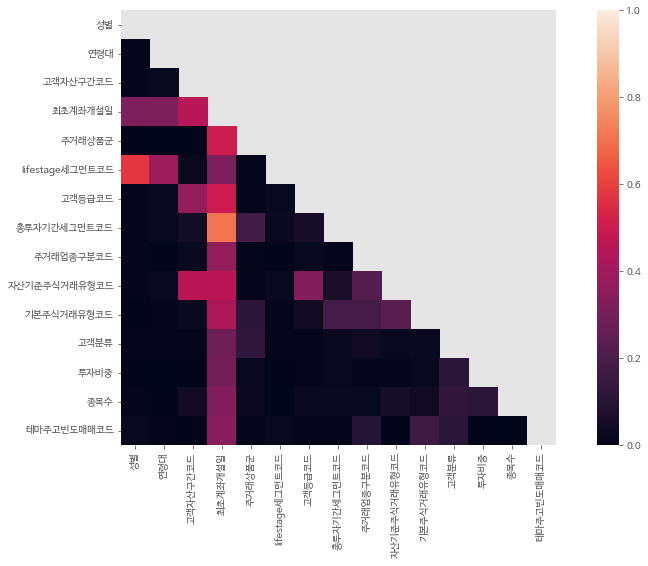

In [ ]:
# matrix를 heatmap으로 표시
mask = np.zeros_like(df_cv_result, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15,8))
ax = sns.heatmap(df_cv_result, mask=mask, vmin=0., vmax=1, square=True)

plt.show()

## 총투자기간에 따른 세부 군집화 실시

### 1) 총투자기간세그먼트코드 = 1, 2인 고객

In [ ]:
# 총투자기간세그먼트코드 = 1, 2
df_tot_ivs_12 = 고객정보분석대상[(고객정보분석대상['총투자기간세그먼트코드'] <= 2)]
df_tot_ivs_12.drop(['고객정보기준년월', 'MTS월단위접속패턴', '수익금액구간코드', '주식상품보유여부', '해외주식상품보유여부', '보유상품유형세그먼트코드', '충성도세그먼트코드', '주거래시장구분코드'], axis=1, inplace=True)

In [ ]:
df_tot_ivs_12.shape

(3807, 17)

In [ ]:
df_tot_ivs_12 = df_tot_ivs_12.astype(str)
df_tot_ivs_12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3807 entries, 7 to 9999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   고객번호             3807 non-null   object
 1   계좌번호             3807 non-null   object
 2   성별               3807 non-null   object
 3   연령대              3807 non-null   object
 4   고객자산구간코드         3807 non-null   object
 5   최초계좌개설일          3807 non-null   object
 6   주거래상품군           3807 non-null   object
 7   lifestage세그먼트코드  3807 non-null   object
 8   고객등급코드           3807 non-null   object
 9   총투자기간세그먼트코드      3807 non-null   object
 10  주거래업종구분코드        3807 non-null   object
 11  자산기준주식거래유형코드     3807 non-null   object
 12  기본주식거래유형코드       3807 non-null   object
 13  고객분류             3807 non-null   object
 14  투자비중             3807 non-null   object
 15  종목수              3807 non-null   object
 16  테마주고빈도매매코드       3807 non-null   object
dtypes: object(17)
memory usage: 535.4

In [ ]:
# k-modes를 사용하기 위해 matrix 형태로 변경
Matrix_tot_ivs_12 = df_tot_ivs_12.iloc[:, 2:].to_numpy()
Matrix_tot_ivs_12

array([['1', '5', '1', ..., '2', '1', '0'],
       ['1', '6', '1', ..., '6', '1', '0'],
       ['2', '1', '1', ..., '6', '1', '0'],
       ...,
       ['1', '2', '1', ..., '4', '1', '0'],
       ['2', '5', '1', ..., '5', '1', '0'],
       ['2', '3', '1', ..., '6', '1', '0']], dtype=object)

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


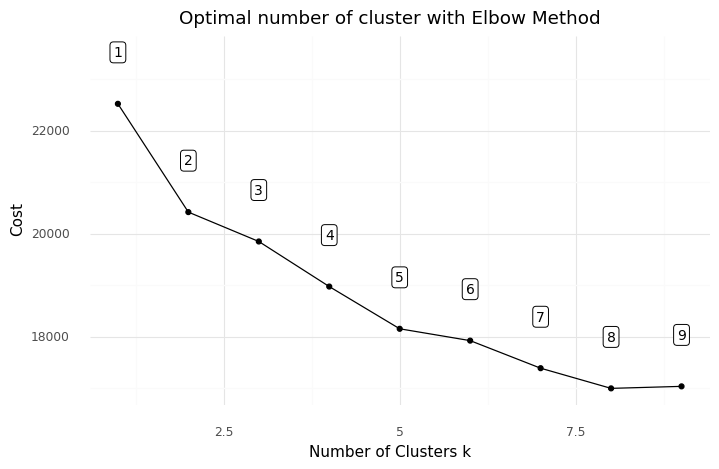

<ggplot: (8777389914741)>

In [ ]:
# k값 선정 elbow method 사용을 위한 코드임
cost = []
for cluster in range(1, 10):
    try:
        kmodes = KModes(n_jobs = -1, n_clusters = cluster,
                       init = 'Huang', random_state = 0)
        kmodes.fit_predict(Matrix_tot_ivs_12)
        cost.append(kmodes.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break


## 결과 변환
df_cost = pd.DataFrame({'Cluster': range(1, 10), 'Cost': cost})

## 그래프 생성
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [ ]:
# cluster 수를 5로 설정
kmodes = KModes(n_jobs = -1, n_clusters = 5, init = 'Huang', random_state = 0)
kmodes.fit_predict(Matrix_tot_ivs_12)

array([0, 0, 4, ..., 0, 0, 1], dtype=uint16)

In [ ]:
# Cluster centroids
kmodes.cluster_centroids_
# Check the iteration
kmodes.n_iter_
# Check the cost
kmodes.cost_

18151.0

In [ ]:
# 분석 결과 cluster를 메인 데이터에 결합
df_tot_ivs_12['Cluster Labels'] = kmodes.labels_
df_tot_ivs_12['Cluster Labels'] = df_tot_ivs_12['Cluster Labels'].astype('category')
df_tot_ivs_12.head()

,고객번호,계좌번호,성별,연령대,고객자산구간코드,최초계좌개설일,주거래상품군,lifestage세그먼트코드,고객등급코드,총투자기간세그먼트코드,주거래업종구분코드,자산기준주식거래유형코드,기본주식거래유형코드,고객분류,투자비중,종목수,테마주고빈도매매코드,Cluster Labels
7,53a63724f090a6c20dc82f6c82ede1504f6a1c292dd24f...,c3154fb182503f9cfe85e307c429f1c699c366377613c5...,1,5,1,20210911,2,5,4,1,16.0,5.0,010,4,2,1,0,0
14,e0150e8c6c65a3063063acbfd984a5bcf569749fb42c81...,414693efcc0862bc7bbf2aae90a9d922489a0659bcff5c...,1,6,1,20210316,2,5,9,1,16.0,5.0,010,4,6,1,0,0
15,392b8915e2173cfac27fdd761527f5b19be4d2d65ce0dd...,60fb190558b2702922f07dc650f2c48be0fc4f63c9a255...,2,1,1,20210624,2,2,9,1,16.0,5.0,010,2,6,1,0,4
16,3af71ed2d924ddcffa3833849d701b1c94ca699f41dc77...,e3a6182ab9b628bce4c330e66a49ef8ad484c772be7c47...,1,5,1,20210930,2,5,5,2,16.0,4.0,010,1,6,2,0,0
17,a1e479c7b399b17795611e49aa97b604060b171fbec43a...,82434b1fa9cd929f68fde4738e9b72accf08cbf473054e...,1,99,1,20220316,1,9,99,1,10.0,5.0,006,5,1,0,0,3


In [ ]:
# Columns for centroids
list_col = ['고객번호', '계좌번호', 'Cluster Labels']
cols = [col for col in df_tot_ivs_12 if col not in list_col]

# Create an index
index = ['군집1', '군집2', '군집3', '군집4', '군집5']

# 군집별 대표값 확인용 data frame 출력
pd.DataFrame(kmodes.cluster_centroids_, columns = cols, index = index)

,성별,연령대,고객자산구간코드,최초계좌개설일,주거래상품군,lifestage세그먼트코드,고객등급코드,총투자기간세그먼트코드,주거래업종구분코드,자산기준주식거래유형코드,기본주식거래유형코드,고객분류,투자비중,종목수,테마주고빈도매매코드
군집1,1,5,1,20210308,2,5,9,1,16.0,5.0,010,4,6,1,0
군집2,2,2,1,20210427,3,2,9,1,16.0,5.0,010,8,6,1,0
군집3,2,4,1,20210308,2,4,9,1,16.0,5.0,010,1,6,1,0
군집4,1,4,1,20210427,2,3,9,1,16.0,5.0,010,0,1,0,0
군집5,2,1,1,20210108,2,2,9,1,16.0,5.0,010,1,6,1,0


In [ ]:
# 고객 분류 결과 중간 저장
df_tot_ivs_12.to_csv('./df_tot_ivs_12.csv')

#### 1-1) 군집화 결과
> 1. 5개 그룹으로 군집화
>
> 2. 고객 자산은 각 그룹별 90% 이상이 0원이상 1천만원미만임<br>
> 따라서 고객 자산에 대한 그룹별 차이는 중요하지 않음
>
> 3. 다만 그룹별 '고객분류' 파생변수에 대한 거래 양상에 큰 차이를 보였음<br>
>> 3-1. 0번 그룹은 국내대형주보다 테마주, 국내중소형주 매매 선호<br>
>> 3-2. 1번 그룹은 해외대형주, 해외ETF, 해외중소형주 매매 선호<br>
>> 3-3. 2번, 4번 그룹은 국내대형주 매매 선호<br>
>> 3-4. 3번 그룹은 비매매 이거나 신규상장주 균등배정매매 고객<br>
>
> 4. 0번 그룹은 테마주 고빈도 매매 고객이 타 그룹대비 가장 많음 (약 12% - 타 그룹은 3~6% 수준)
>
> 5. 3번 그룹은 기본주식거래유형에서 Long-Term Trader 고객이 타 그룹대비 가장 많음 (약 16.46% - 타 그룹은 2~3% 수준)
>
> 6. 1번 그룹은 기본주식거래유형에서 Stock Holder 고객이 타 그룹대비 가장 많음 (약 81.63% - 타 그룹은 55~57% 수준)
----------
(참고)
- 각 그룹은 최종 데이터에서 0 ~ 4로 라벨링 하였음
- 아래는 군집 결과에 대한 주요 시각화 코드임

In [ ]:
# 5개 군집(0 ~ 4)별 고객수
df_tot_ivs_12.groupby(['Cluster Labels'])['고객번호'].count()

Cluster Labels
0    1345
1     479
2     846
3     474
4     663
Name: 고객번호, dtype: int64

In [ ]:
# 군집별 자산구간 비율
cross_tab = pd.crosstab(index=df_tot_ivs_12['Cluster Labels'],
                        columns=df_tot_ivs_12['고객자산구간코드'])

cross_tab_prop = pd.crosstab(index=df_tot_ivs_12['Cluster Labels'],
                             columns=df_tot_ivs_12['고객자산구간코드']).apply(lambda r: r/r.sum(), axis=1)
cross_tab_prop

고객자산구간코드,1,2,3,4,5,6
Cluster Labels,,,,,,
0,0.910781,0.058736,0.011896,0.011152,0.005204,0.002230
1,0.947808,0.037578,0.010438,0.000000,0.002088,0.002088
2,0.929078,0.043735,0.013002,0.009456,0.004728,0.000000
3,0.978903,0.012658,0.004219,0.002110,0.002110,0.000000
4,0.972851,0.022624,0.003017,0.000000,0.001508,0.000000


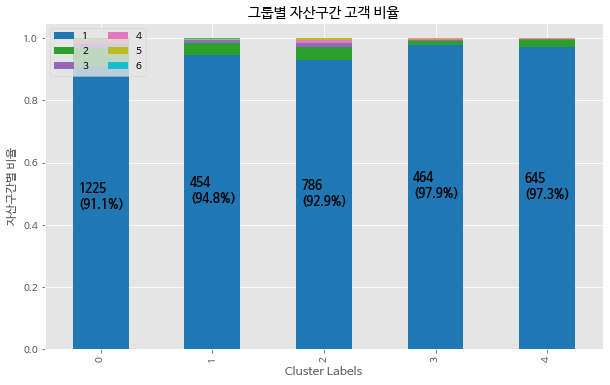

In [ ]:
# 비율 시각화
cross_tab_prop.plot(kind='bar',
                    stacked=True,
                    colormap='tab10',
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Cluster Labels")
plt.ylabel("자산구간별 비율")
plt.title("그룹별 자산구간 고객 비율")

for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
        if count > 400:
            plt.text(x=n - 0.2,
                    y=(y_loc - proportion) + (proportion / 2),
                    s=f'{count}\n({np.round(proportion * 100, 1)}%)',
                    color="black",
                    fontsize=12,
                    fontweight="bold")

plt.show()

In [ ]:
# 군집별 '고객분류' 파생변수 비율
cross_tab = pd.crosstab(index=df_tot_ivs_12['Cluster Labels'],
                        columns=df_tot_ivs_12['고객분류'])

cross_tab_prop = pd.crosstab(index=df_tot_ivs_12['Cluster Labels'],
                             columns=df_tot_ivs_12['고객분류']).apply(lambda r: r/r.sum(), axis=1)
cross_tab_prop

고객분류,0,1,2,3,4,5,6,7,8
Cluster Labels,,,,,,,,,
0,0.000000,0.188848,0.275093,0.026022,0.405204,0.040892,0.034944,0.006691,0.022305
1,0.004175,0.000000,0.073069,0.008351,0.118998,0.091858,0.169102,0.058455,0.475992
2,0.001182,0.600473,0.193853,0.031915,0.112293,0.040189,0.010638,0.002364,0.007092
3,0.654008,0.021097,0.044304,0.002110,0.006329,0.251055,0.008439,0.006329,0.006329
4,0.000000,0.805430,0.067873,0.030166,0.085973,0.007541,0.001508,0.000000,0.001508


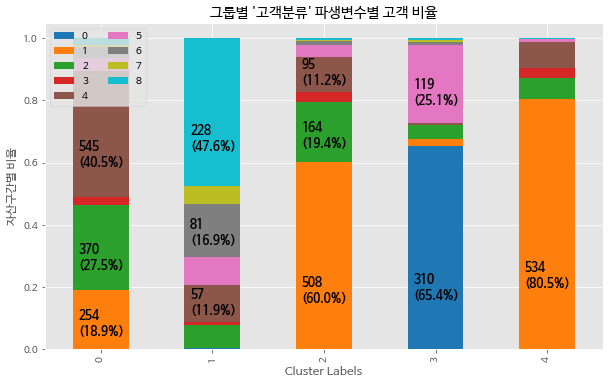

In [ ]:
# 비율 시각화
cross_tab_prop.plot(kind='bar',
                    stacked=True,
                    colormap='tab10',
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Cluster Labels")
plt.ylabel("자산구간별 비율")
plt.title("그룹별 '고객분류' 파생변수별 고객 비율")

for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
        if np.round(proportion * 100, 1) > 10:
            plt.text(x=n - 0.2,
                    y=(y_loc - proportion) + (proportion / 4),
                    s=f'{count}\n({np.round(proportion * 100, 1)}%)',
                    color="black",
                    fontsize=12,
                    fontweight="bold")

plt.show()

### 2) 총투자기간세그먼트코드 = 3 인 고객

In [ ]:
고객정보분석대상.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   고객번호             10000 non-null  object 
 1   계좌번호             10000 non-null  object 
 2   고객정보기준년월         10000 non-null  object 
 3   MTS월단위접속패턴       10000 non-null  int64  
 4   성별               10000 non-null  int64  
 5   연령대              10000 non-null  int64  
 6   고객자산구간코드         10000 non-null  int64  
 7   수익금액구간코드         10000 non-null  int64  
 8   최초계좌개설일          10000 non-null  int64  
 9   주식상품보유여부         10000 non-null  object 
 10  해외주식상품보유여부       10000 non-null  object 
 11  주거래상품군           10000 non-null  int64  
 12  lifestage세그먼트코드  10000 non-null  int64  
 13  고객등급코드           10000 non-null  int64  
 14  총투자기간세그먼트코드      10000 non-null  int64  
 15  보유상품유형세그먼트코드     10000 non-null  float64
 16  충성도세그먼트코드        10000 non-null  float64
 17  주거래시장구분코드    

In [ ]:
# 총투자기간세그먼트코드 = 3
df_tot_ivs_3 = 고객정보분석대상[(고객정보분석대상['총투자기간세그먼트코드'] == 3)]

In [ ]:
df_tot_ivs_3.drop(['고객정보기준년월', 'MTS월단위접속패턴', '수익금액구간코드', '주식상품보유여부', '해외주식상품보유여부', '보유상품유형세그먼트코드', '충성도세그먼트코드', '주거래시장구분코드'], axis=1, inplace=True)

In [ ]:
df_tot_ivs_3.shape

(4629, 17)

In [ ]:
df_tot_ivs_3 = df_tot_ivs_3.astype(str)

In [ ]:
df_tot_ivs_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4629 entries, 0 to 9997
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   고객번호             4629 non-null   object
 1   계좌번호             4629 non-null   object
 2   성별               4629 non-null   object
 3   연령대              4629 non-null   object
 4   고객자산구간코드         4629 non-null   object
 5   최초계좌개설일          4629 non-null   object
 6   주거래상품군           4629 non-null   object
 7   lifestage세그먼트코드  4629 non-null   object
 8   고객등급코드           4629 non-null   object
 9   총투자기간세그먼트코드      4629 non-null   object
 10  주거래업종구분코드        4629 non-null   object
 11  자산기준주식거래유형코드     4629 non-null   object
 12  기본주식거래유형코드       4629 non-null   object
 13  고객분류             4629 non-null   object
 14  투자비중             4629 non-null   object
 15  종목수              4629 non-null   object
 16  테마주고빈도매매코드       4629 non-null   object
dtypes: object(17)
memory usage: 651.0

In [ ]:
Matrix_tot_ivs_3 = df_tot_ivs_3.iloc[:, 2:].to_numpy()
Matrix_tot_ivs_3

array([['1', '4', '1', ..., '6', '3', '0'],
       ['1', '7', '1', ..., '6', '1', '0'],
       ['1', '5', '1', ..., '4', '1', '0'],
       ...,
       ['1', '2', '1', ..., '2', '1', '0'],
       ['2', '3', '1', ..., '6', '2', '0'],
       ['2', '3', '1', ..., '6', '3', '1']], dtype=object)

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


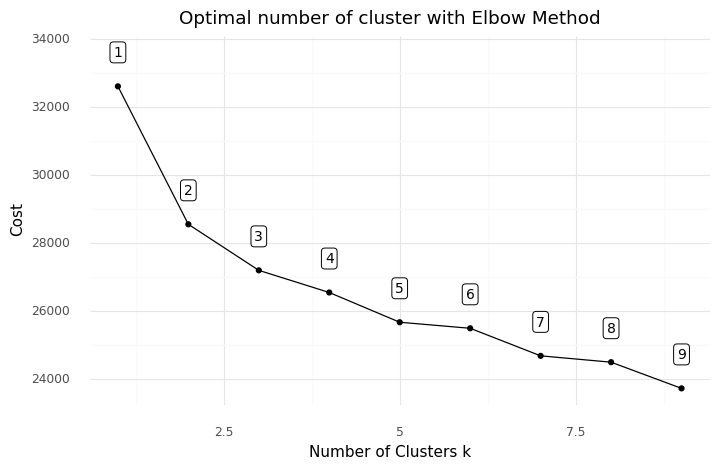

<ggplot: (8777405887613)>

In [ ]:
# Choosing optimal K
cost = []
for cluster in range(1, 10):
    try:
        kmodes = KModes(n_jobs = -1, n_clusters = cluster,
                       init = 'Huang', random_state = 0)
        kmodes.fit_predict(Matrix_tot_ivs_3)
        cost.append(kmodes.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break


# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster': range(1, 10), 'Cost': cost})

# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [ ]:
# cluster 수를 5으로 설정
kmodes = KModes(n_jobs = -1, n_clusters = 5, init = 'Huang', random_state = 0)
kmodes.fit_predict(Matrix_tot_ivs_3)

array([3, 3, 3, ..., 3, 0, 0], dtype=uint16)

In [ ]:
# Cluster centroid
kmodes.cluster_centroids_
# Check the iteration of the clusters created
kmodes.n_iter_
# Check the cost of the clusters created
kmodes.cost_

25664.0

In [ ]:
# 분석 결과 cluster를 메인 데이터에 결합
df_tot_ivs_3['Cluster Labels'] = kmodes.labels_
df_tot_ivs_3['Cluster Labels'] = df_tot_ivs_3['Cluster Labels'].astype('category')
df_tot_ivs_3.head()

,고객번호,계좌번호,성별,연령대,고객자산구간코드,최초계좌개설일,주거래상품군,lifestage세그먼트코드,고객등급코드,총투자기간세그먼트코드,주거래업종구분코드,자산기준주식거래유형코드,기본주식거래유형코드,고객분류,투자비중,종목수,테마주고빈도매매코드,Cluster Labels
0,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,1,4,1,20050309,2,3,9,3,16.0,5.0,009,1,6,3,0,3
1,3072d776c716010235dd75b3195d760bf3c46e00deee4e...,afa2e6df88371acd0768c15a14aebf9e81ed131af729e3...,1,7,1,20091013,2,5,9,3,16.0,5.0,008,1,6,1,0,3
2,dc6eb520d8a2ca7fcc5e95aef37120b8b1d91a3d30bd7e...,726a3295019efd88142038b123013623e26a217d2b08df...,1,5,1,20110914,2,5,9,3,16.0,5.0,010,2,4,1,0,3
4,a93943ad4a16323cd7ffb6efb3f52fe566139304ec6bde...,8010d50edbbcd1974e12cb20fbca3a3abea0088df3070e...,2,4,1,20151005,2,4,9,3,16.0,5.0,010,5,1,0,0,0
5,ff6680be8395283839f6cd930d473ff222af176c10249b...,f7310c919e32e5857cf1252ff2500ef4a264ee8677e481...,2,9,2,20170804,2,9,5,3,16.0,4.0,010,2,6,1,0,2


In [ ]:
# Columns for centroids
list_col = ['고객번호', '계좌번호', 'Cluster Labels']
cols = [col for col in df_tot_ivs_3 if col not in list_col]

# Create an index
index = ['군집1', '군집2', '군집3', '군집4', '군집5']

# Create data frame
pd.DataFrame(kmodes.cluster_centroids_, columns = cols, index = index)

,성별,연령대,고객자산구간코드,최초계좌개설일,주거래상품군,lifestage세그먼트코드,고객등급코드,총투자기간세그먼트코드,주거래업종구분코드,자산기준주식거래유형코드,기본주식거래유형코드,고객분류,투자비중,종목수,테마주고빈도매매코드
군집1,2,3,1,20210308,2,4,9,3,16.0,5.0,010,1,6,1,0
군집2,2,6,3,20200325,2,5,4,3,16.0,3.0,004,1,6,1,0
군집3,1,7,2,20210308,2,5,5,3,16.0,4.0,010,1,6,1,0
군집4,1,2,1,20210110,2,2,9,3,16.0,5.0,010,1,6,1,0
군집5,1,1,1,20200323,2,2,9,3,16.0,5.0,010,1,6,2,0


In [ ]:
# Save data frame
df_tot_ivs_3.to_csv('./df_tot_ivs_3.csv')

#### 2-1) 군집화 결과
> 1. 5개 그룹으로 군집화
>
> 2. 고객 자산은 0, 3, 4번 그룹의 약 90%의 고객이 0원이상 1천만원미만임<br>
> 다만 1번 그룹은 자산이 3천만원 이상인 고객이 약 80% 수준이며,<br>
> 2번 그룹은 자산이 1천만원이상 3천만원 미만인 고객이 약 75% 수준이다.
>
> 3. 또한 자산이 많은 고객일수록 더 많은 종목을 보유
>
> 4. 자산에 따른 차이와 달리 '고객분류' 파생변수에 대한 고객 세분화는 명확히 나타나지 않았다.<br>
> 모든 그룹에 대해서 국내대형주를 가장 많이 선호(약 50~57%)<br>
> 해외주식 비율도 각 그룹별로 비슷한 모습을 보였다.
>
> 5. 자산이 많은 1번 그룹은 기본주식거래유형에서 Stock Holder 고객의 비율은 12% 수준으로 낮으며, 타 그룹대비 Day Trader(10.51%), Swing Trader(14.11%), General Trader(37.24%)의 비율이 높음
>
----------
(참고)
- 각 그룹 0 ~ 4는 최종 데이터에서 5 ~ 9로 새로 라벨링 하였음
- 아래는 군집 결과에 대한 주요 시각화 코드임

In [ ]:
# 5개 군집(0 ~ 4)별 고객수
df_tot_ivs_3.groupby(['Cluster Labels'])['고객번호'].count()

Cluster Labels
0    1441
1     666
2    1242
3     956
4     324
Name: 고객번호, dtype: int64

In [ ]:
# 군집별 자산구간 비율
cross_tab = pd.crosstab(index=df_tot_ivs_3['Cluster Labels'],
                        columns=df_tot_ivs_3['고객자산구간코드'])

cross_tab_prop = pd.crosstab(index=df_tot_ivs_3['Cluster Labels'],
                             columns=df_tot_ivs_3['고객자산구간코드']).apply(lambda r: r/r.sum(), axis=1)
cross_tab_prop

고객자산구간코드,1,2,3,4,5,6
Cluster Labels,,,,,,
0,0.891742,0.056905,0.006246,0.014573,0.022901,0.007634
1,0.049550,0.136637,0.456456,0.280781,0.066066,0.010511
2,0.184380,0.756844,0.004831,0.018519,0.028180,0.007246
3,0.965481,0.006276,0.013598,0.010460,0.004184,0.000000
4,0.916667,0.009259,0.006173,0.024691,0.040123,0.003086


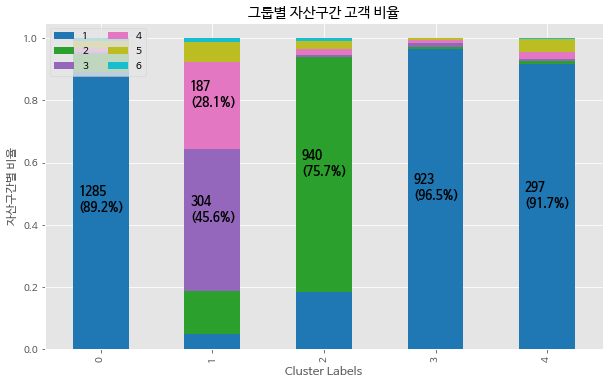

In [ ]:
# 비율 시각화
cross_tab_prop.plot(kind='bar',
                    stacked=True,
                    colormap='tab10',
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Cluster Labels")
plt.ylabel("자산구간별 비율")
plt.title("그룹별 자산구간 고객 비율")

for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
        if np.round(proportion * 100, 1) > 20:
            plt.text(x=n - 0.2,
                    y=(y_loc - proportion) + (proportion / 2),
                    s=f'{count}\n({np.round(proportion * 100, 1)}%)',
                    color="black",
                    fontsize=12,
                    fontweight="bold")

plt.show()

In [ ]:
# 군집별 종목수 비율
cross_tab = pd.crosstab(index=df_tot_ivs_3['Cluster Labels'],
                        columns=df_tot_ivs_3['종목수'])

cross_tab_prop = pd.crosstab(index=df_tot_ivs_3['Cluster Labels'],
                             columns=df_tot_ivs_3['종목수']).apply(lambda r: r/r.sum(), axis=1)
cross_tab_prop

종목수,0,1,2,3,4,5,6,7
Cluster Labels,,,,,,,,
0,0.011797,0.490632,0.224844,0.148508,0.071478,0.023595,0.015267,0.013879
1,0.012012,0.249249,0.175676,0.205706,0.138138,0.072072,0.084084,0.063063
2,0.004831,0.365539,0.252013,0.182770,0.103865,0.045089,0.025765,0.020129
3,0.041841,0.634937,0.154812,0.105649,0.041841,0.011506,0.006276,0.003138
4,0.021605,0.003086,0.842593,0.104938,0.018519,0.006173,0.003086,0.000000


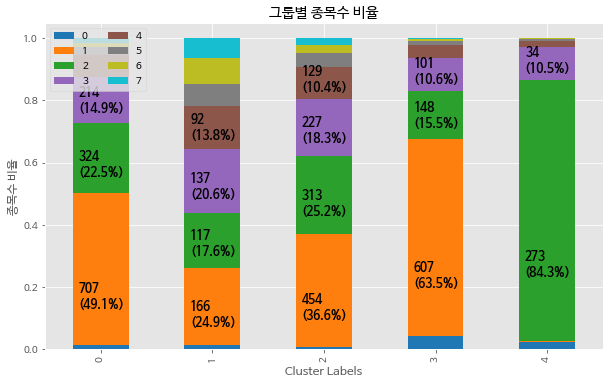

In [ ]:
# 비율 시각화
cross_tab_prop.plot(kind='bar',
                    stacked=True,
                    colormap='tab10',
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Cluster Labels")
plt.ylabel("종목수 비율")
plt.title("그룹별 종목수 비율")

for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
        if np.round(proportion * 100, 1) > 10:
            plt.text(x=n - 0.2,
                    y=(y_loc - proportion) + (proportion / 4),
                    s=f'{count}\n({np.round(proportion * 100, 1)}%)',
                    color="black",
                    fontsize=12,
                    fontweight="bold")

plt.show()

In [ ]:
# 군집별 '고객분류' 파생변수 비율
cross_tab = pd.crosstab(index=df_tot_ivs_3['Cluster Labels'],
                        columns=df_tot_ivs_3['고객분류'])

cross_tab_prop = pd.crosstab(index=df_tot_ivs_3['Cluster Labels'],
                             columns=df_tot_ivs_3['고객분류']).apply(lambda r: r/r.sum(), axis=1)
cross_tab_prop

고객분류,0,1,2,3,4,5,6,7,8
Cluster Labels,,,,,,,,,
0,0.011103,0.573213,0.151284,0.020125,0.170021,0.001388,0.044414,0.006246,0.022207
1,0.012012,0.507508,0.184685,0.012012,0.216216,0.000000,0.046547,0.000000,0.021021
2,0.004831,0.518519,0.156200,0.020129,0.195652,0.000000,0.052335,0.009662,0.042673
3,0.037657,0.501046,0.160042,0.016736,0.163180,0.006276,0.054393,0.011506,0.049163
4,0.021605,0.561728,0.104938,0.027778,0.172840,0.000000,0.067901,0.009259,0.033951


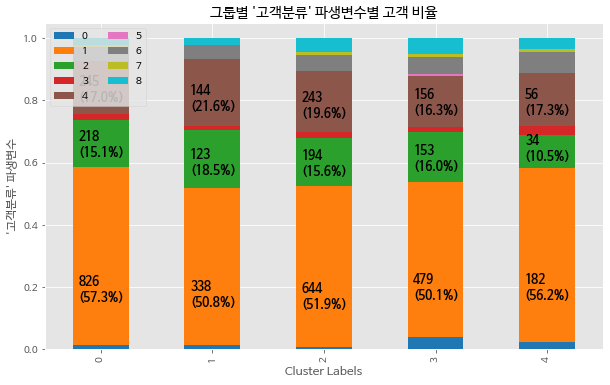

In [ ]:
# 비율 시각화
cross_tab_prop.plot(kind='bar',
                    stacked=True,
                    colormap='tab10',
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Cluster Labels")
plt.ylabel("'고객분류' 파생변수")
plt.title("그룹별 '고객분류' 파생변수별 고객 비율")

for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
        if np.round(proportion * 100, 1) > 10:
            plt.text(x=n - 0.2,
                    y=(y_loc - proportion) + (proportion / 4),
                    s=f'{count}\n({np.round(proportion * 100, 1)}%)',
                    color="black",
                    fontsize=12,
                    fontweight="bold")

plt.show()

In [ ]:
# 군집별 '기본주식거래유형' 비율
cross_tab = pd.crosstab(index=df_tot_ivs_3['Cluster Labels'],
                        columns=df_tot_ivs_3['기본주식거래유형코드'])

cross_tab_prop = pd.crosstab(index=df_tot_ivs_3['Cluster Labels'],
                             columns=df_tot_ivs_3['기본주식거래유형코드']).apply(lambda r: r/r.sum(), axis=1)
cross_tab_prop

기본주식거래유형코드,001,002,003,004,005,006,007,008,009,010,011,_
Cluster Labels,,,,,,,,,,,,
0,0.009715,0.022901,0.066620,0.132547,0.045108,0.020125,0.000000,0.097155,0.115198,0.489938,0.000000,0.000694
1,0.034535,0.105105,0.141141,0.372372,0.033033,0.015015,0.000000,0.100601,0.070571,0.127628,0.000000,0.000000
2,0.013688,0.045894,0.121578,0.193237,0.037037,0.015298,0.000805,0.134461,0.091787,0.345411,0.000000,0.000805
3,0.006276,0.015690,0.035565,0.140167,0.051255,0.014644,0.000000,0.089958,0.117155,0.521967,0.002092,0.005230
4,0.006173,0.024691,0.061728,0.175926,0.015432,0.033951,0.000000,0.101852,0.098765,0.481481,0.000000,0.000000


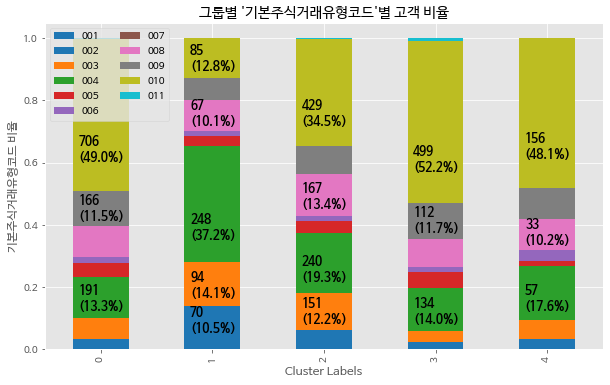

In [ ]:
# 비율 시각화
cross_tab_prop.plot(kind='bar',
                    stacked=True,
                    colormap='tab10',
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Cluster Labels")
plt.ylabel("기본주식거래유형코드 비율")
plt.title("그룹별 '기본주식거래유형코드'별 고객 비율")

for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
        if np.round(proportion * 100, 1) > 10:
            plt.text(x=n - 0.2,
                    y=(y_loc - proportion) + (proportion / 5),
                    s=f'{count}\n({np.round(proportion * 100, 1)}%)',
                    color="black",
                    fontsize=12,
                    fontweight="bold")

plt.show()

### 3) 총투자기간세그먼트코드 = 4 이상인 고객

In [ ]:
고객정보분석대상.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   고객번호             10000 non-null  object 
 1   계좌번호             10000 non-null  object 
 2   고객정보기준년월         10000 non-null  object 
 3   MTS월단위접속패턴       10000 non-null  int64  
 4   성별               10000 non-null  int64  
 5   연령대              10000 non-null  int64  
 6   고객자산구간코드         10000 non-null  int64  
 7   수익금액구간코드         10000 non-null  int64  
 8   최초계좌개설일          10000 non-null  int64  
 9   주식상품보유여부         10000 non-null  object 
 10  해외주식상품보유여부       10000 non-null  object 
 11  주거래상품군           10000 non-null  int64  
 12  lifestage세그먼트코드  10000 non-null  int64  
 13  고객등급코드           10000 non-null  int64  
 14  총투자기간세그먼트코드      10000 non-null  int64  
 15  보유상품유형세그먼트코드     10000 non-null  float64
 16  충성도세그먼트코드        10000 non-null  float64
 17  주거래시장구분코드    

In [ ]:
# 총투자기간세그먼트코드 = 4 이상
df_tot_ivs_4 = 고객정보분석대상[(고객정보분석대상['총투자기간세그먼트코드'] >= 4)]

In [ ]:
df_tot_ivs_4.drop(['고객정보기준년월', 'MTS월단위접속패턴', '수익금액구간코드', '주식상품보유여부', '해외주식상품보유여부', '보유상품유형세그먼트코드', '충성도세그먼트코드', '주거래시장구분코드'], axis=1, inplace=True)

In [ ]:
df_tot_ivs_4.shape

(1564, 17)

In [ ]:
df_tot_ivs_4 = df_tot_ivs_4.astype(str)

In [ ]:
df_tot_ivs_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1564 entries, 3 to 9989
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   고객번호             1564 non-null   object
 1   계좌번호             1564 non-null   object
 2   성별               1564 non-null   object
 3   연령대              1564 non-null   object
 4   고객자산구간코드         1564 non-null   object
 5   최초계좌개설일          1564 non-null   object
 6   주거래상품군           1564 non-null   object
 7   lifestage세그먼트코드  1564 non-null   object
 8   고객등급코드           1564 non-null   object
 9   총투자기간세그먼트코드      1564 non-null   object
 10  주거래업종구분코드        1564 non-null   object
 11  자산기준주식거래유형코드     1564 non-null   object
 12  기본주식거래유형코드       1564 non-null   object
 13  고객분류             1564 non-null   object
 14  투자비중             1564 non-null   object
 15  종목수              1564 non-null   object
 16  테마주고빈도매매코드       1564 non-null   object
dtypes: object(17)
memory usage: 219.9

In [ ]:
Matrix_tot_ivs_4 = df_tot_ivs_4.iloc[:, 2:].to_numpy()
Matrix_tot_ivs_4

array([['1', '6', '5', ..., '6', '1', '0'],
       ['1', '6', '1', ..., '6', '1', '0'],
       ['2', '3', '3', ..., '6', '3', '0'],
       ...,
       ['2', '9', '3', ..., '5', '2', '0'],
       ['1', '5', '1', ..., '6', '1', '0'],
       ['2', '7', '1', ..., '6', '1', '0']], dtype=object)

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


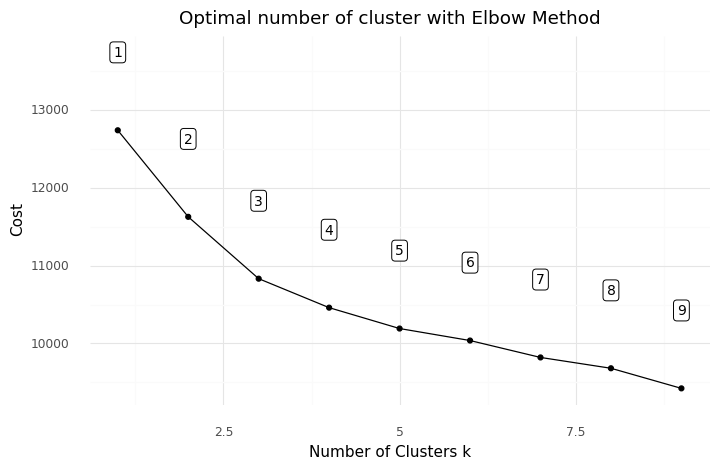

<ggplot: (8777405676265)>

In [ ]:
# Choosing optimal K
cost = []
for cluster in range(1, 10):
    try:
        kmodes = KModes(n_jobs = -1, n_clusters = cluster,
                       init = 'Huang', random_state = 0)
        kmodes.fit_predict(Matrix_tot_ivs_4)
        cost.append(kmodes.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break


# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster': range(1, 10), 'Cost': cost})

# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [ ]:
# cluster 수를 3으로 설정
kmodes = KModes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kmodes.fit_predict(Matrix_tot_ivs_4)

array([1, 1, 0, ..., 2, 1, 1], dtype=uint16)

In [ ]:
# Cluster centroid
kmodes.cluster_centroids_
# Check the iteration of the clusters created
kmodes.n_iter_
# Check the cost of the clusters created
kmodes.cost_

10832.0

In [ ]:
# 분석 결과 cluster를 메인 데이터에 결합
df_tot_ivs_4['Cluster Labels'] = kmodes.labels_
df_tot_ivs_4['Cluster Labels'] = df_tot_ivs_4['Cluster Labels'].astype('category')
df_tot_ivs_4.head()

,고객번호,계좌번호,성별,연령대,고객자산구간코드,최초계좌개설일,주거래상품군,lifestage세그먼트코드,고객등급코드,총투자기간세그먼트코드,주거래업종구분코드,자산기준주식거래유형코드,기본주식거래유형코드,고객분류,투자비중,종목수,테마주고빈도매매코드,Cluster Labels
3,d11e0b4608537bc4cf260a2af2d5e04f0a1c58219c5008...,4f2a78f9a162f9c82350f40627ce1062afaefeb4ff34e7...,1,6,5,20150915,2,7,3,4,16.0,3.0,008,2,6,1,0,1
6,70b361ffdfc614a2e17b7ffa57f949f0a2ceb84f021ded...,7a7cb253b2f7172299c5c051c489ad90a6599190ef3683...,1,6,1,20171011,2,5,9,4,16.0,5.0,010,4,6,1,0,1
8,771a23c5dd069e7a49dc3e4dc841f6af99ec6b3715cfee...,f2094bb718670ded9d4fc39b1f0a96c87bb6455f506b0b...,2,3,3,20180127,2,4,4,4,16.0,3.0,008,4,6,3,0,0
19,d53dc5659335d2fb56ae8a1447001b25596ffb6a90ad32...,d228b5089dbf31671a8224d54c1d5e742a5ecc8bff8cf7...,2,9,2,19881212,2,9,4,6,9.0,4.0,004,1,6,3,0,0
21,dd6425f22ae52007f19e69710bf3b8518f1cbde471947e...,985b9026520770ce99df811dcc69a1df90611c267b7cd1...,1,6,1,20070608,2,7,9,5,16.0,5.0,010,4,6,1,0,1


In [ ]:
# Columns for centroids
list_col = ['고객번호', '계좌번호', 'Cluster Labels']
cols = [col for col in df_tot_ivs_4 if col not in list_col]

# Create an index
index = ['군집1', '군집2', '군집3']

# Create data frame
pd.DataFrame(kmodes.cluster_centroids_, columns = cols, index = index)

,성별,연령대,고객자산구간코드,최초계좌개설일,주거래상품군,lifestage세그먼트코드,고객등급코드,총투자기간세그먼트코드,주거래업종구분코드,자산기준주식거래유형코드,기본주식거래유형코드,고객분류,투자비중,종목수,테마주고빈도매매코드
군집1,2,7,2,20180514,2,5,5,4,16.0,4.0,010,1,6,1,0
군집2,1,7,1,20190405,2,5,9,4,16.0,5.0,010,4,6,1,0
군집3,1,9,4,19990728,2,5,4,6,16.0,3.0,010,1,6,1,0


In [ ]:
# Save data frame
df_tot_ivs_4.to_csv('./df_tot_ivs_4.csv')

#### 3-1) 군집화 결과
> 1. **3개** 그룹으로 군집화
>
> 2. 고객 lifestage 세그먼트 확인 결과, 앞서 군집화한 그룹에 비해 가족성숙기 ~ 은퇴기 고객이 다수를 차지<br>
> 특히 2번 그룹의 경우, 은퇴기 고객의 비율이 30% 가까운 모습을 보임
>
> 3. 고객 자산은 1번 < 0번 < 2번 그룹 순서로 2번 그룹이 가장 많았음<br>
>
> 4. 종목수는 0번과 2번 그룹이 큰 차이를 보이지 않음.
>
> 5. '고객분류' 파생변수에 대해서도 0번과 2번이 큰 차이를 보이지는 않았으나,<br>
> 대체로 국내대형주를 선호하였다.<br>
> 단, 자산이 상대적으로 적었던 1번 그룹은 국내중소형주를 더욱 선호하였다.
>
> 6. 또한 앞서 군집화한 경우와 다르게 기본주식거래유형에서도 Stock Holder의 비율은 상대적으로 낮은편이었다.<br>
> {0: 34%, 1: 49%, 2: 31%}<br>
> 자산이 많을수록 Day Trader, Swing Trader, General Trader의 비율이 높았다.
----------
(참고)
- 각 그룹 0 ~ 2는 최종 데이터에서 10 ~ 12로 새로 라벨링 하였음
- 아래는 군집 결과에 대한 주요 시각화 코드임

In [ ]:
# 3개 군집(0 ~ 2)별 고객수
df_tot_ivs_4.groupby(['Cluster Labels'])['고객번호'].count()

Cluster Labels
0    629
1    519
2    416
Name: 고객번호, dtype: int64

In [ ]:
# 군집별 고객 life stage segment 비율
cross_tab = pd.crosstab(index=df_tot_ivs_4['Cluster Labels'],
                        columns=df_tot_ivs_4['lifestage세그먼트코드'])

cross_tab_prop = pd.crosstab(index=df_tot_ivs_4['Cluster Labels'],
                             columns=df_tot_ivs_4['lifestage세그먼트코드']).apply(lambda r: r/r.sum(), axis=1)
cross_tab_prop

lifestage세그먼트코드,1,10,2,3,4,5,6,7,8,9,99
Cluster Labels,,,,,,,,,,,
0,0.007949,0.023847,0.039746,0.073132,0.112878,0.357711,0.157393,0.062003,0.049285,0.116057,0.000000
1,0.017341,0.019268,0.044316,0.115607,0.063584,0.421965,0.100193,0.092486,0.017341,0.105973,0.001927
2,0.000000,0.048077,0.014423,0.098558,0.014423,0.355769,0.076923,0.076923,0.019231,0.290865,0.004808


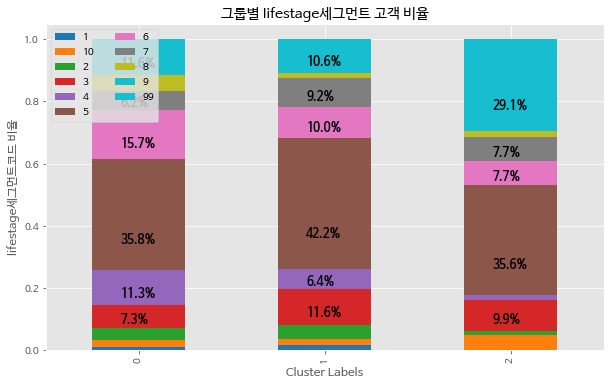

In [ ]:
# 비율 시각화
cross_tab_prop.plot(kind='bar',
                    stacked=True,
                    colormap='tab10',
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Cluster Labels")
plt.ylabel("lifestage세그먼트코드 비율")
plt.title("그룹별 lifestage세그먼트 고객 비율")

for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
        if np.round(proportion * 100, 1) > 5:
            plt.text(x=n - 0.1,
                    y=(y_loc - proportion) + (proportion / 4),
                    s=f'{np.round(proportion * 100, 1)}%',
                    color="black",
                    fontsize=12,
                    fontweight="bold")

plt.show()

In [ ]:
# 군집별 자산구간 비율
cross_tab = pd.crosstab(index=df_tot_ivs_4['Cluster Labels'],
                        columns=df_tot_ivs_4['고객자산구간코드'])

cross_tab_prop = pd.crosstab(index=df_tot_ivs_4['Cluster Labels'],
                             columns=df_tot_ivs_4['고객자산구간코드']).apply(lambda r: r/r.sum(), axis=1)
cross_tab_prop

고객자산구간코드,1,2,3,4,5,6
Cluster Labels,,,,,,
0,0.166932,0.621622,0.074722,0.033386,0.087440,0.015898
1,0.795761,0.017341,0.057803,0.019268,0.086705,0.023121
2,0.009615,0.079327,0.283654,0.463942,0.144231,0.019231


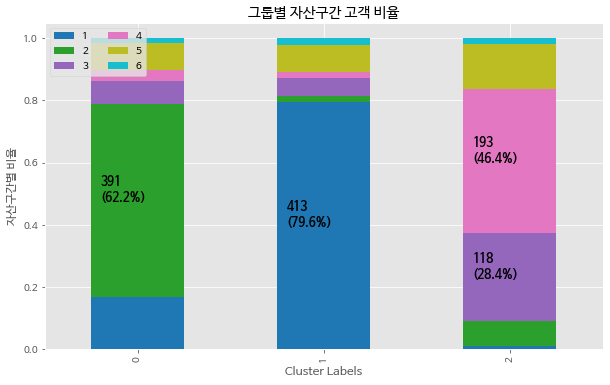

In [ ]:
# 비율 시각화
cross_tab_prop.plot(kind='bar',
                    stacked=True,
                    colormap='tab10',
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Cluster Labels")
plt.ylabel("자산구간별 비율")
plt.title("그룹별 자산구간 고객 비율")

for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
        if np.round(proportion * 100, 1) > 20:
            plt.text(x=n - 0.2,
                    y=(y_loc - proportion) + (proportion / 2),
                    s=f'{count}\n({np.round(proportion * 100, 1)}%)',
                    color="black",
                    fontsize=12,
                    fontweight="bold")

plt.show()

In [ ]:
# 군집별 고객분류 비율
cross_tab = pd.crosstab(index=df_tot_ivs_4['Cluster Labels'],
                        columns=df_tot_ivs_4['고객분류'])

cross_tab_prop = pd.crosstab(index=df_tot_ivs_4['Cluster Labels'],
                             columns=df_tot_ivs_4['고객분류']).apply(lambda r: r/r.sum(), axis=1)
cross_tab_prop

고객분류,0,1,2,3,4,5,6,7,8
Cluster Labels,,,,,,,,,
0,0.014308,0.430843,0.233704,0.009539,0.267091,0.00159,0.020668,0.003180,0.019078
1,0.065511,0.227360,0.188825,0.015414,0.472062,0.00578,0.005780,0.001927,0.017341
2,0.012019,0.507212,0.209135,0.012019,0.237981,0.00000,0.012019,0.000000,0.009615


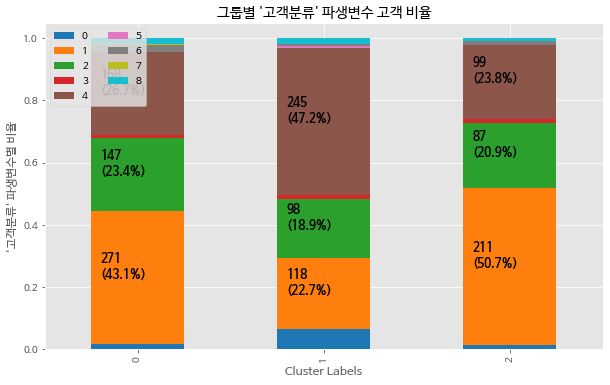

In [ ]:
# 비율 시각화
cross_tab_prop.plot(kind='bar',
                    stacked=True,
                    colormap='tab10',
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Cluster Labels")
plt.ylabel("'고객분류' 파생변수별 비율")
plt.title("그룹별 '고객분류' 파생변수 고객 비율")

for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
        if np.round(proportion * 100, 1) > 15:
            plt.text(x=n - 0.2,
                    y=(y_loc - proportion) + (proportion / 2),
                    s=f'{count}\n({np.round(proportion * 100, 1)}%)',
                    color="black",
                    fontsize=12,
                    fontweight="bold")

plt.show()

In [ ]:
# 군집별 기본주식거래유형 비율
cross_tab = pd.crosstab(index=df_tot_ivs_4['Cluster Labels'],
                        columns=df_tot_ivs_4['기본주식거래유형코드'])

cross_tab_prop = pd.crosstab(index=df_tot_ivs_4['Cluster Labels'],
                             columns=df_tot_ivs_4['기본주식거래유형코드']).apply(lambda r: r/r.sum(), axis=1)
cross_tab_prop

기본주식거래유형코드,0,001,002,003,004,005,006,008,009,010,011,_
Cluster Labels,,,,,,,,,,,,
0,0.000000,0.017488,0.066773,0.120827,0.197138,0.034976,0.017488,0.104928,0.095390,0.341812,0.001590,0.001590
1,0.001927,0.019268,0.059730,0.077071,0.125241,0.032755,0.015414,0.086705,0.069364,0.491329,0.009634,0.011561
2,0.000000,0.019231,0.081731,0.139423,0.204327,0.043269,0.014423,0.091346,0.088942,0.312500,0.002404,0.002404


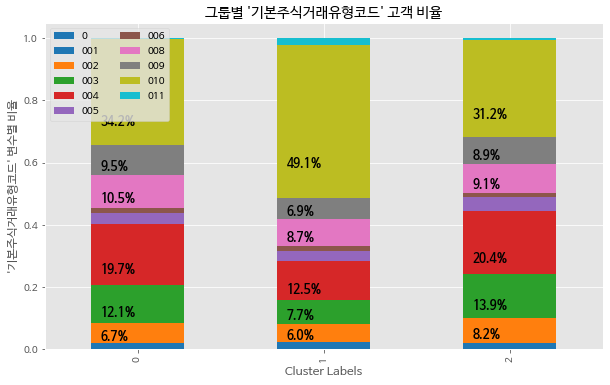

In [ ]:
# 비율 시각화
cross_tab_prop.plot(kind='bar',
                    stacked=True,
                    colormap='tab10',
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Cluster Labels")
plt.ylabel("'기본주식거래유형코드' 변수별 비율")
plt.title("그룹별 '기본주식거래유형코드' 고객 비율")

for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
        if np.round(proportion * 100, 1) > 5:
            plt.text(x=n - 0.2,
                    y=(y_loc - proportion) + (proportion / 5),
                    s=f'{np.round(proportion * 100, 1)}%',
                    color="black",
                    fontsize=12,
                    fontweight="bold")

plt.show()

In [ ]:
# Load data
# df_tot_ivs_12 = pd.read_csv("./df_tot_ivs_12.csv", index_col=0)
# df_tot_ivs_3 = pd.read_csv("./df_tot_ivs_3.csv", index_col=0)
# df_tot_ivs_4 = pd.read_csv("./df_tot_ivs_4.csv", index_col=0)

## 최종 데이터 생성



### 군집분석 결과 정리
- **고객의 투자기간에 따라 1년 미만, 1-3년, 3년이상으로 구분**
> - 고객의 투자기간이 1년 미만인 경우:<br>
> <ins>타 그룹에 비해 자산이 적고 보유 종목에 따른 고객 분류별로 고객 군집이 형성됨.</ins><br>
> 즉, 고객별로 나타나는 뚜렷한 특징이 없기에 **고객분류**에 따라 고객군집이 형성된 것으로 보임.<br>
> 이러한 경우 고객별로 충분한 거래데이터가 쌓이기 전까지 <ins>수익률이 높았던 성공적인 포트폴리오를 다양하게 추천</ins>하는 것이 효과적일 것으로 보임.
>
> - 고객의 투자기간이 1-3년인 경우:<br>
> <b>자산</b>에 따라서 군집 분석이 이루어졌고, 군집별로 투자 종목의 차이가 유의미 하지 않고, <b>전체적인 투자 종목 분포와 유사</b>함. 즉, <ins>거래데이터를 기반으로 투자자 성향에 따라 상품 및 주식을 추천하는 것이 효과적일 것으로 보임.</ins>
>
> - 고객의 투자기간이 3년이상인 경우:<br>
> <b>자산</b>에 따라서 군집 분석이 이루어졌고, 자산이 적은 고객군들에서는 국내중소형주 투자 비율이 늘어났고, 자산이 많은 고객군들에서는 전체적인 투자 종목 분포와 유사하게 국내대형주 위주의 투자를 하였음. <ins>자산이 적은 고객군들한테는 다양한 분야의 주식 및 고위험 상품을 추천</ins>할 수 있으나, <ins>기본적으로 거래데이터를 기반으로 한 투자자 성향에 따라 상품 및 주식을 추천하는 것이 효과적일 것으로 보임.</ins>

--------------------------

아래는 최종 데이터 생성을 위한 코드임

In [ ]:
df_tot_ivs_12['Cluster Labels'] = df_tot_ivs_12['Cluster Labels'].astype(int)
df_tot_ivs_3['Cluster Labels'] = df_tot_ivs_3['Cluster Labels'].astype(int)
df_tot_ivs_4['Cluster Labels'] = df_tot_ivs_4['Cluster Labels'].astype(int)

In [ ]:
df_tot_ivs_3['Cluster Labels'] = df_tot_ivs_3['Cluster Labels'] + 5
df_tot_ivs_4['Cluster Labels'] = df_tot_ivs_4['Cluster Labels'] + 10
print(df_tot_ivs_3['Cluster Labels'].value_counts())
print(df_tot_ivs_4['Cluster Labels'].value_counts())

5    1441
7    1242
8     956
6     666
9     324
Name: Cluster Labels, dtype: int64
10    629
11    519
12    416
Name: Cluster Labels, dtype: int64


In [ ]:
frames = [df_tot_ivs_12, df_tot_ivs_3, df_tot_ivs_4]
df_tot_ivs_result = pd.concat(frames)
df_tot_ivs_result

,고객번호,계좌번호,성별,연령대,고객자산구간코드,최초계좌개설일,주거래상품군,lifestage세그먼트코드,고객등급코드,총투자기간세그먼트코드,주거래업종구분코드,자산기준주식거래유형코드,기본주식거래유형코드,고객분류,투자비중,종목수,테마주고빈도매매코드,Cluster Labels
7,53a63724f090a6c20dc82f6c82ede1504f6a1c292dd24f...,c3154fb182503f9cfe85e307c429f1c699c366377613c5...,1,5,1,20210911,2,5,4,1,16.0,5.0,010,4,2,1,0,0
14,e0150e8c6c65a3063063acbfd984a5bcf569749fb42c81...,414693efcc0862bc7bbf2aae90a9d922489a0659bcff5c...,1,6,1,20210316,2,5,9,1,16.0,5.0,010,4,6,1,0,0
15,392b8915e2173cfac27fdd761527f5b19be4d2d65ce0dd...,60fb190558b2702922f07dc650f2c48be0fc4f63c9a255...,2,1,1,20210624,2,2,9,1,16.0,5.0,010,2,6,1,0,4
16,3af71ed2d924ddcffa3833849d701b1c94ca699f41dc77...,e3a6182ab9b628bce4c330e66a49ef8ad484c772be7c47...,1,5,1,20210930,2,5,5,2,16.0,4.0,010,1,6,2,0,0
17,a1e479c7b399b17795611e49aa97b604060b171fbec43a...,82434b1fa9cd929f68fde4738e9b72accf08cbf473054e...,1,99,1,20220316,1,9,99,1,10.0,5.0,006,5,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9959,661b00c4ccb8d795dd5ffa5b69c2d8c9cffc7e1ba59787...,faac1d9aa1b991b54ade3dc4b0de8a54ee63b9278d05c2...,1,4,4,20090909,2,3,4,6,10.0,3.0,004,1,6,1,0,12
9960,d2481d9acb5acca4e4b85da572e77e9599fd6cd7faf108...,c7687e2a562173a02be3b00bd8df8dbcf4051ff15e16fe...,1,5,6,20180823,2,5,1,4,10.0,1.0,001,2,2,3,1,11
9964,755a96553c81e96cc84083ac02305f1049bcbb38985d7f...,8119d6cb9c5a72b255e84ba7d6ec0c44776ba8fff7fd5c...,2,9,3,20070619,2,9,4,6,13.0,3.0,002,2,5,2,0,12
9979,db090e6aa8f0c66ff47880f3ba80c480e1b84f7737e7ce...,671dd90fb90ed6a495d2fe8e4d64d041bbae27d73c4991...,1,5,1,20070601,2,5,9,6,16.0,4.0,010,4,6,1,0,11


In [ ]:
# 고객 분류 데이터 생성을 위한 join
df_result = pd.merge(고객정보분석대상, df_tot_ivs_result[['고객번호', 'Cluster Labels']], on='고객번호', how='inner')

# 최종 고객 분류 데이터 생성 (팀명_분류결과.csv)
df_result.to_csv("./AIM_분류결과.csv")